In [1]:
#!pip uninstall tensorflow
#!pip install tensorflow==2.12 -q
#!pip install tensorflow_probability -q
# Пакет ниже необходим для сохранения в формат parquet
#!pip install pyarrow -q
# Пакет ниже необходим для from src.features.risk_score import RiskScore
#!pip install pyextremes -q
#!pip install streamlit -q
#!pip install missingno -q

In [2]:
import os
import numpy as np
import math
import pandas as pd
import pickle
import joblib
import json
import uuid

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.path.append(r"C:\Users\User\Documents\TASKS\PEGAZ\code\pegaz_models-VAE")
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from pyextremes.models import MLE
from scipy.stats import genpareto
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
#from src.data.preprocessing_old import preprocessing_step_1_info, preprocessing_step_2_filter
#from src.data.preprocessing import preprocessing_step1, preprocessing_step2
from inference import ModelInference
from inference_old import ModelInference as ModelInferenceOld
from src.data.make_data import remove_outliers, remove_stops, remove_features, find_flats, find_peaks
from src.data.time_series_train_val_split import train_val_split_windows
from src.features.risk_score import RiskScore
from src.models.VAE import DenseVAE, NegloglikeLoss, learning_rate_estimate # или любую другую модель из доступных
from src.models.VariationalAE_v2 import VAE
from src.utils.save_model import serialize_data, metadata
from src.visualization.visualize import plot_anomaly, nans_threshold

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
def remove_quantiles(df, upper_quatiles_range = [0.9975, 0.99999], lower_quatiles_range = [0.0001, 0.002],  step = 0.0001):
    for c in df.columns:
        qs = np.arange(upper_quatiles_range[0], upper_quatiles_range[1], step = step)
        quantiles = df[c].quantile(qs)
        differences = np.diff(quantiles)
        max_derivative_index = np.argmax(differences)  # Find the index of the maximum difference
        max_derivative_quantile = qs[max_derivative_index + 1]
        upper_thrs = quantiles[max_derivative_quantile]

        qs = np.arange(lower_quatiles_range[0], lower_quatiles_range[1], step = step)
        quantiles = df[c].quantile(qs)
        differences = np.diff(quantiles) 
        max_derivative_index = np.argmax(differences)  # Find the index of the maximum difference
        max_derivative_quantile = qs[max_derivative_index + 1]
        lower_thrs = quantiles[max_derivative_quantile]
        if upper_thrs > df[c].quantile(0.9):
            df.loc[(df[c] >= upper_thrs) ] = np.nan
        if lower_thrs < df[c].quantile(0.1):
            df.loc[(df[c] <= lower_thrs)] = np.nan
            
            
def safe_ln(x):
    if x > 0:
        return np.log(x)
    elif x < 0:
        return -1 * np.log(abs(x))
    else:
        return np.log(x+1.0)

In [25]:
import tensorflow as tf

In [26]:
tf.__version__

'2.12.0'

## Вводные данные проекта

In [4]:
# Компанию пришлось назвать латиницей, так как с кириллицей tensorflow отказался работать
COMPANY = 'Messoyakha'
EQUIPMENT_NUM = 1
EQUIPMENT = fr'GPA{EQUIPMENT_NUM}'
print(EQUIPMENT)

# Максимальная разница между интервалами в минутах, чтобы считать их одним интервалом
delta_mi_max = 10

# https://github.com/tensorflow/tensorboard/issues/2023
# https://github.com/tensorflow/tensorflow/issues/26021
suffix = ''
data_path = os.path.join(r'C:\Users\User\Documents\TASKS\PEGAZ\datasets', COMPANY)
print(data_path)
data_path_processed = os.path.join(data_path, 'processed', EQUIPMENT+suffix)
print(data_path_processed)
data_path_models = os.path.join(data_path, 'models', EQUIPMENT+suffix)
print(data_path_models)
data_path_systems = r'C:\Users\User\Documents\TASKS\PEGAZ\datasets\Разбивка_тегов_по_моделям'
print(data_path_systems)

GPA1
C:\Users\User\Documents\TASKS\PEGAZ\datasets\Messoyakha
C:\Users\User\Documents\TASKS\PEGAZ\datasets\Messoyakha\processed\GPA1
C:\Users\User\Documents\TASKS\PEGAZ\datasets\Messoyakha\models\GPA1
C:\Users\User\Documents\TASKS\PEGAZ\datasets\Разбивка_тегов_по_моделям


## Загрузка данных

In [5]:
#Описания тегов
tags = pd.read_excel(os.path.join(data_path, 'external', 'tags_MNG_setpoints_v5.xlsx'))
tags['ID'] = tags['ID'].astype(int).astype(str)
tags = tags[['ID', 'TagName', 'Description', 'Unit', 'Нижняя граница', 'Верхняя граница']][(tags['system'] == fr'gpa{EQUIPMENT_NUM}')]
print(tags.shape)
tags.head(3)

(1709, 6)


,ID,TagName,Description,Unit,Нижняя граница,Верхняя граница
214,2435,06.02.10.04.009.GPA1.NKU02.TEST_Set_07UV581,(ТЕСТ) Вентилятор №1 07-УВ581 Регулировка скор...,%,0.0,100.0
215,2454,06.02.10.04.009.GPA1.NKU06.TEST_Set_10UV581,(ТЕСТ) Вентилятор №1 10-УВ582 Регулировка скор...,%,0.0,100.0
216,2475,06.02.10.04.009.GPA1.NKU08.TEST_Set_07UV582,(ТЕСТ) Вентилятор №2 07-УВ582 Регулировка скор...,%,0.0,100.0


In [98]:
tags[tags.duplicated(['ID']) == True].shape

(101, 6)

In [6]:
#Теги подсистем
systems = pd.read_excel(os.path.join(data_path, 'models', fr"{COMPANY}_{EQUIPMENT}_models.xlsx"), 
                        sheet_name=EQUIPMENT)
systems['ID'] = systems['ID'].astype(int).astype(str)
replacer = pd.Series(systems['ID'].values + '. ' + systems['Description'].values, index=systems['ID'])
model_names = ['KVD_GAS_M_V1', 'KVD_MECH_M_V1', 'KND_GAS_M_V1', 'KND_MECH_V1', 'Drive_m_v1', 'Geabox_m_V1', 
               'DGS_KND_m_v1', 'DGS_KVD_m_v1', 'FLOWPATH_v1', 'FLOWPATH_v2', 'FLOWPATH_v3', 'FLOWPATH_v4', 
               'FLOWPATH_v5', 'FLOWPATH_v6', 'FLOWPATH_v7']

model_replacer = {model_names[0]: 'КВД газовая часть',
                  model_names[1]: 'КВД механическая часть',
                  model_names[2]: 'КНД газовая часть',
                  model_names[3]: 'КНД механическая часть',
                  model_names[4]: 'Двигатель',
                  model_names[5]: 'Мультипликатор',
                  model_names[6]: 'ДГС КНД',
                  model_names[7]: 'ДГС КВД',
                  model_names[8]: 'Проточная часть',
                  model_names[9]: 'Проточная часть 2',
                  model_names[10]: 'Проточная часть 3',
                  model_names[11]: 'Проточная часть 4',
                  model_names[12]: 'Проточная часть 5',
                  model_names[13]: 'Проточная часть 6',
                  model_names[14]: 'Проточная часть 7'}

sys_dict = {}
need_cols = np.array([])
for col in model_names:
    sys_dict[col] = systems[systems[col] == 1]['ID'].values
    need_cols = np.append(need_cols, sys_dict[col])

need_cols = np.unique(need_cols)

if EQUIPMENT_NUM == 1:
    mode_tag = '1360' # '1511'
else:
    mode_tag = '2544' # '2687'

print('Режимный тег:', mode_tag)
print(systems.shape)
print(replacer.shape)
print(len(sys_dict))
print(len(need_cols))

Режимный тег: 1360
(1709, 36)
(1709,)
15
252


In [7]:
tags_cols = list(tags['ID'].values)
systems_cols = list(systems['ID'].values)
print([col for col in tags_cols if col not in systems_cols])
print([col for col in systems_cols if col not in tags_cols])

[]
[]


In [7]:
#Основной датасет
file_name = fr'{EQUIPMENT}_20220101_20230601.parquet'
df_metrics_raw = pd.read_parquet(os.path.join(data_path_processed, file_name))
df_metrics_raw = df_metrics_raw[need_cols].copy()

print(file_name)
print(df_metrics_raw.shape)
print(df_metrics_raw.index.min(), df_metrics_raw.index.max())
print(df_metrics_raw.isna().sum().sum())
df_metrics_raw.head(3)

GPA1_20220101_20230601.parquet
(719629, 252)
2022-01-01 00:01:00 2023-06-01 00:00:00
0


,1299,1302,1303,1309,1310,1311,1312,1315,1316,1318,...,298,299,300,301,302,303,304,305,306,307
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:01:00,57.335999,0.719971,0.320007,8235.200195,11364.000000,5147.520020,5637.839844,6450.240234,7064.640137,0.2949,...,95.056000,114.407997,31.770000,38.742001,28.992001,24.077999,31.870001,42.512001,29.336000,24.006001
2022-01-01 00:02:00,57.604000,0.880005,0.400024,8208.000000,11326.400391,5161.439941,5656.560059,6459.520020,7079.040039,0.2944,...,95.120003,114.496002,32.012001,38.590000,28.340000,22.964001,31.724001,42.467999,28.813999,23.299999
2022-01-01 00:03:00,58.419998,0.880005,0.400024,8192.799805,11305.599609,5166.959961,5664.720215,6467.520020,7090.560059,0.2963,...,95.047997,114.599998,32.902000,38.877998,28.106001,22.563999,32.301998,42.911999,28.614000,22.608000


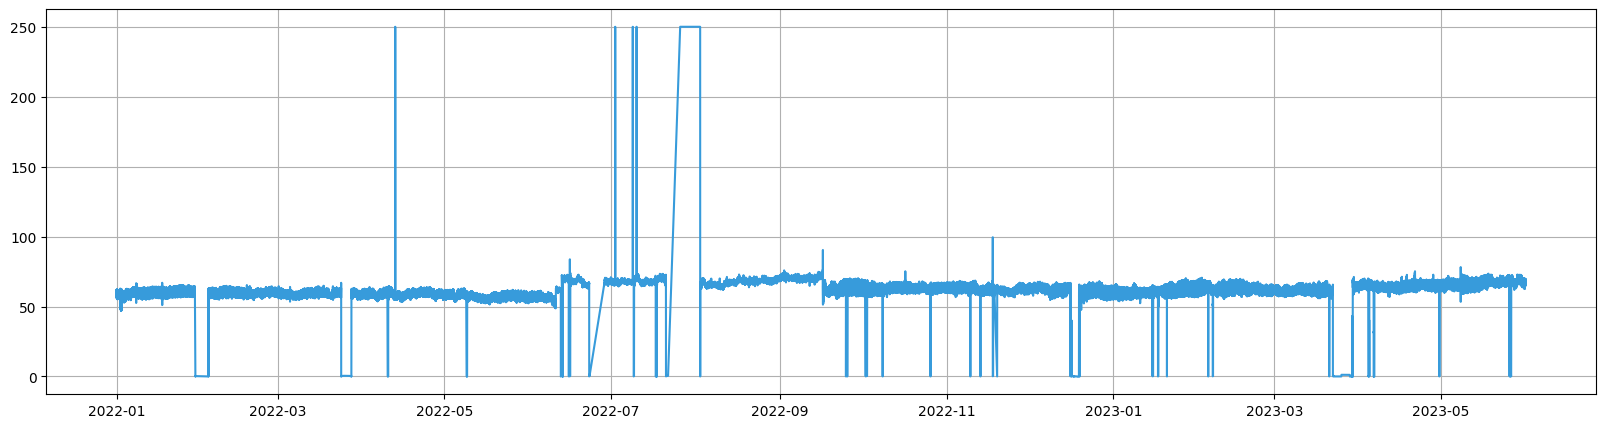

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(df_metrics_raw[mode_tag], color='#379BDB')
#start_pos = pd.to_datetime('12.05.2022 00:00:00', dayfirst=True)
#end_pos = pd.to_datetime('12.09.2022 00:00:00', dayfirst=True)
#plt.plot(df_metrics_raw.loc[start_pos:end_pos, mode_tag], color='#379BDB')
#df_metrics_raw = df_metrics_raw.loc[:end_pos, :]
#plt.plot(df_metrics_raw.loc[~mask_stops, '163'], color='#379BDB')
#plt.ylim([50,100])
plt.grid(True)
plt.show()
plt.close()

## Предобработка данных

Изначально: 719629 строк, 252 фичей
Останов:  57829
Залипшие значения:  2138336
Пики:  4651615


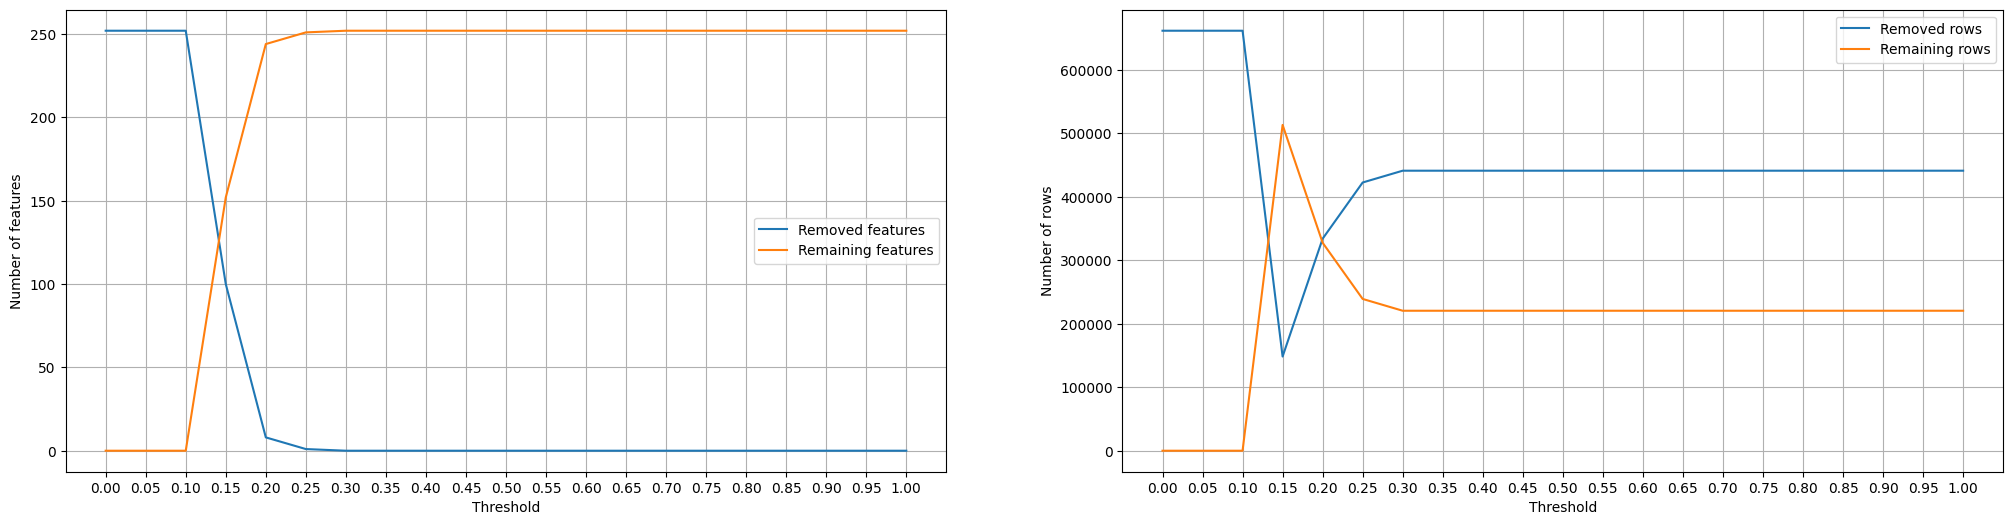

Dropped columns: 1787 1848 2073 2115 2152 2154 2187 234
После фильтрации: 327712 строк, 244 фичей
0
CPU times: total: 6min 56s
Wall time: 7min 21s


In [10]:
%%time

interpolate_limit = 10

print(f'Изначально: {df_metrics_raw.shape[0]} строк, {df_metrics_raw.shape[1]} фичей')

df_metrics = remove_outliers(df_metrics_raw, tags, tags_features=['ID', 'Нижняя граница', 'Верхняя граница'])
# Маска остановок
mask_stops = remove_stops(data=df_metrics,
                          col_name=mode_tag,
                          low_limit=53,
                          high_limit=75,
                          steps_to_stop=210,
                          steps_to_regime=210,
                          return_mask=True)
df_metrics = df_metrics[~mask_stops]
print('Останов: ', sum(mask_stops))

flats_mask = find_flats(df_metrics)
df_metrics = df_metrics[~flats_mask]
print('Залипшие значения: ', flats_mask.sum().sum())

peaks_mask = find_peaks(df_metrics, window=60, influence=0.2, threshold=3)
df_metrics = df_metrics[~peaks_mask]
print('Пики: ', peaks_mask.sum().sum())

remove_quantiles(df_metrics)

nans_threshold(df_metrics.interpolate(limit=interpolate_limit))

df_metrics = remove_features(df_metrics, limit_nans=0.2)
print(f'После фильтрации: {df_metrics.shape[0]} строк, {df_metrics.shape[1]} фичей')
print(df_metrics.isna().sum().sum())

In [35]:
start_pos = pd.to_datetime('01.07.2022 00:00:00', dayfirst=True)
end_pos = pd.to_datetime('03.07.2022 00:00:00', dayfirst=True)
df_tmp = df_metrics_raw.loc[start_pos:end_pos, '3339']

In [36]:
df_tmp.to_excel(os.path.join(data_path_processed, "df_tmp.xlsx"))

In [15]:
df_metrics = pd.read_parquet(os.path.join(data_path_processed, EQUIPMENT+'_preprocessed_flowpath.parquet'))
print(df_metrics.shape)
print(df_metrics.index.min(), df_metrics.index.max())

(328782, 244)
2022-01-02 00:32:00 2023-05-25 23:33:00


In [11]:
n = 60
df_metrics = df_metrics.rolling(n).mean()
df_metrics = df_metrics[n-1:]
print(df_metrics.shape)

(327653, 244)


### Выборка для обучения

In [14]:
start_pos = pd.to_datetime('19.06.2022 00:00:00', dayfirst=True)
#end_pos = pd.to_datetime('30.09.2022 23:59:00', dayfirst=True)
end_pos = pd.to_datetime('12.09.2022 23:59:00', dayfirst=True)
print(df_metrics.loc[start_pos:end_pos, mode_tag].shape)
#df_metrics.loc[start_pos:end_pos, mode_tag].tail(3)
df_train = df_metrics.loc[start_pos:end_pos, :]

start_pos = pd.to_datetime('09.10.2022 00:00:00', dayfirst=True)
#end_pos = pd.to_datetime('14.02.2023 23:59:00', dayfirst=True)
end_pos = pd.to_datetime('24.12.2022 23:59:00', dayfirst=True)
print(df_metrics.loc[start_pos:end_pos, mode_tag].shape)
#df_metrics.loc[start_pos:end_pos, mode_tag].tail(3)
df_train2 = df_metrics.loc[start_pos:end_pos, :]
df_train2 = df_train2[df_train.columns]
df_train = pd.concat([df_train, df_train2])
print(df_train.shape)

(24217,)
(71442,)
(95659, 244)


In [14]:
n = 1440*7
df_metrics_s = df_metrics.rolling(n).mean()
df_metrics_s = df_metrics_s[n-1:]

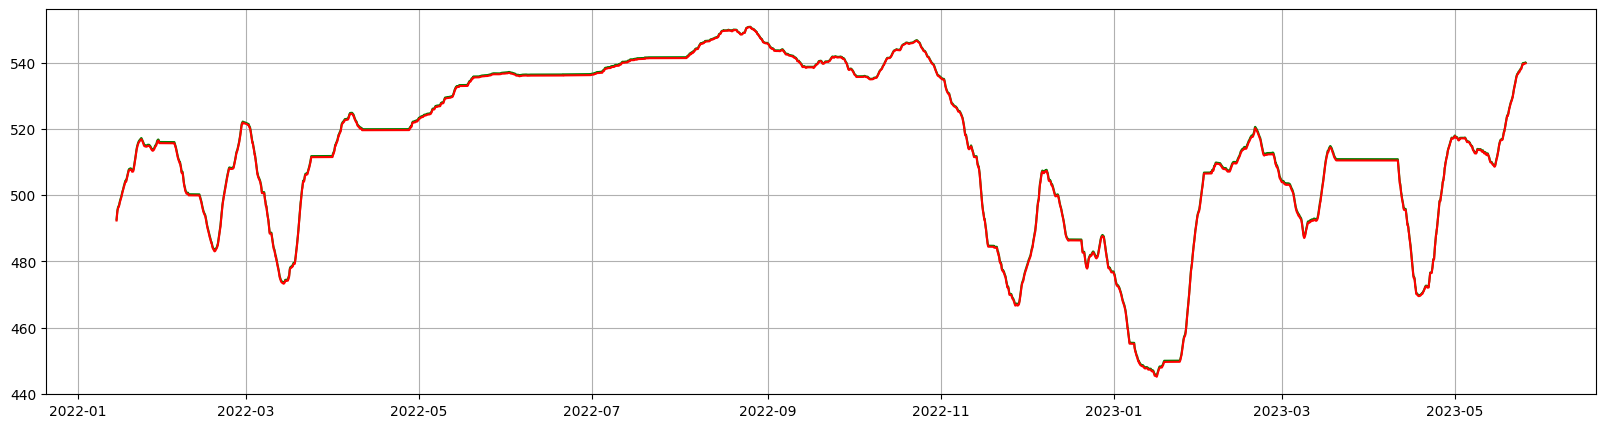

In [20]:
tag = '1397'
plt.figure(figsize=(20, 5))
#plt.plot(df_train[mode_tag], color='#379BDB')
#plt.plot(df_metrics_raw.loc[df_metrics.index, tag], color='#379BDB')
plt.plot(df_metrics_s[tag], color='g')
plt.plot(df_metrics_s['2200'], color='r')
#plt.ylim([50,100])
plt.grid(True)
plt.show()
plt.close()

In [16]:
train, val, _ = train_val_split_windows(df=df_train, train_size=0.9)
#train, val = train_test_split(df_train, test_size=0.1, random_state=7, shuffle=False)
print(train.shape, val.shape)

(86443, 244) (9216, 244)


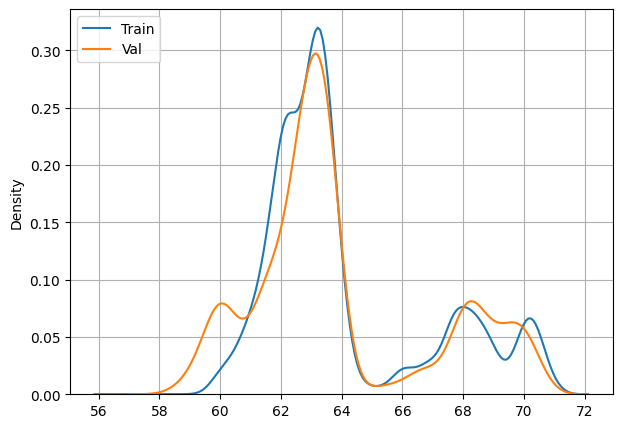

In [17]:
plt.figure(figsize=(7,5))
sns.kdeplot(train[mode_tag].to_numpy(), label='Train')
sns.kdeplot(val[mode_tag].to_numpy(), label='Val')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()
plt.close()

### Сохранение

In [18]:
train.to_parquet(os.path.join(data_path_processed, EQUIPMENT+'_train_flowpath.parquet'))
print(train.shape)
val.to_parquet(os.path.join(data_path_processed, EQUIPMENT+'_val_flowpath.parquet'))
print(val.shape)
df_metrics.to_parquet(os.path.join(data_path_processed, EQUIPMENT+'_preprocessed_flowpath.parquet'))
print(df_metrics.shape)

(86443, 244)
(9216, 244)
(327653, 244)


### Загрузка train/val/test

In [8]:
preprocessed_dfs = {}
preprocessed_dfs['train'] = pd.read_parquet(os.path.join(data_path_processed, 
                                                         EQUIPMENT+'_train_flowpath.parquet'))
print(preprocessed_dfs['train'].shape)
print(preprocessed_dfs['train'].isna().sum().sum())
print(preprocessed_dfs['train'].index.min(), preprocessed_dfs['train'].index.max())

preprocessed_dfs['val'] = pd.read_parquet(os.path.join(data_path_processed, 
                                                       EQUIPMENT+'_val_flowpath.parquet'))
print(preprocessed_dfs['val'].shape)
print(preprocessed_dfs['val'].isna().sum().sum())
print(preprocessed_dfs['val'].index.min(), preprocessed_dfs['val'].index.max())

df_metrics = pd.read_parquet(os.path.join(data_path_processed, EQUIPMENT+'_preprocessed_flowpath.parquet'))
print(df_metrics.shape)
print(df_metrics.index.min(), df_metrics.index.max())

DATA_RANGE = [min(preprocessed_dfs['train'].index.min(), preprocessed_dfs['val'].index.min()).strftime('%Y-%m-%d %H:%M:%S'), 
              max(preprocessed_dfs['train'].index.max(), preprocessed_dfs['val'].index.max()).strftime('%Y-%m-%d %H:%M:%S')]
print(DATA_RANGE)

(86753, 244)
0
2022-06-20 22:05:00 2022-12-24 23:59:00
(9072, 244)
0
2022-08-05 12:12:00 2022-12-15 11:17:00
(328782, 244)
2022-01-02 00:32:00 2023-05-25 23:33:00
['2022-06-20 22:05:00', '2022-12-24 23:59:00']


In [20]:
print([col for col in need_cols if col not in preprocessed_dfs['train'].columns])

['1665', '1666', '1667', '1787', '1848', '2073', '2115', '2152', '2154', '2187', '234']


In [37]:
periods = pd.period_range(start=preprocessed_dfs['train'].index.min(), 
                          end=preprocessed_dfs['train'].index.max(),
                          freq='M')
for i, _ in enumerate(periods):
    period_name = periods[i].strftime('%Y-%m')
    print(period_name, preprocessed_dfs['train'][period_name].shape[0])

2022-06 421
2022-07 4661
2022-08 12328
2022-09 5069
2022-10 21749
2022-11 23485
2022-12 19040


In [58]:
model_name = 'FLOWPATH_v4'
df_metrics[sys_dict[model_name]].sum()

1311    1.755554e+09
1315    2.203976e+09
1319    2.904029e+05
1356    2.904193e+05
1360    2.046178e+07
1395   -3.160573e+06
1397    1.679776e+08
1796    3.321272e+07
2200    1.678840e+08
dtype: float64

## Новая модель

In [169]:
for model_name in ['FLOWPATH_v7']: #model_names:
    scaler = RobustScaler()
    batch_size = 1024 #8192
    validation_split = None
    train_data_system = preprocessed_dfs['train'][sys_dict[model_name]]
    val_data_system = preprocessed_dfs['val'][sys_dict[model_name]]
    #test_data_system = preprocessed_dfs['test'][sys_dict[model_name]]
    train_scaled = scaler.fit_transform(train_data_system)
    val_scaled = scaler.transform(val_data_system)
    #test_scaled = scaler.transform(test_data_system)
    input_shape = train_scaled.shape[-1]
    enc_shape = [input_shape, input_shape//2]
    dec_shape = [input_shape//2, input_shape]
    latent_dim = input_shape//4
    num_comps = 3
    lr = 0.01 #0.001
    epochs = 200 #1000
    verbose = 1
    vae = DenseVAE(input_shape,
                   enc_shape,
                   dec_shape,
                   latent_dim,
                   prior_train=True,
                   prior_type="MultNormal",
                   gaus_noise=0.51,
                   dropout=0.025,
                   num_comps=num_comps,
                   random_seed=1
                   )

    #callbacks = [LearningRateScheduler(learning_rate_estimate, verbose=1)]
    callback_list = [callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.2,
                                                patience=10,
                                                verbose=1),
                     callbacks.EarlyStopping(monitor='val_loss',
                                             min_delta=0,
                                             patience=50,
                                             verbose=1,
                                             restore_best_weights=False) #True
                    ]

    vae.compile(optimizer=Nadam(learning_rate=lr), 
                loss=NegloglikeLoss(), 
                metrics=[metrics.MeanAbsoluteError()])

    history = vae.fit(train_scaled,train_scaled,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=verbose,
                      callbacks=callback_list,
                      validation_split=validation_split,
                      validation_data=(val_scaled, val_scaled))
    
    scores = vae.decoder(vae.encoder(train_scaled).mean()).log_prob(train_scaled).numpy()

Epoch 1/200
85/85 [==============================] - 4s 14ms/step - loss: 8.0269 - mean_absolute_error: 0.7150 - val_loss: 4.2822 - val_mean_absolute_error: 0.4518 - lr: 0.0100
Epoch 2/200
85/85 [==============================] - 1s 7ms/step - loss: 4.7205 - mean_absolute_error: 0.4384 - val_loss: 3.0996 - val_mean_absolute_error: 0.3929 - lr: 0.0100
Epoch 3/200
85/85 [==============================] - 1s 7ms/step - loss: 4.4240 - mean_absolute_error: 0.4182 - val_loss: 3.0319 - val_mean_absolute_error: 0.3885 - lr: 0.0100
Epoch 4/200
85/85 [==============================] - 1s 7ms/step - loss: 4.3652 - mean_absolute_error: 0.4136 - val_loss: 2.9531 - val_mean_absolute_error: 0.3859 - lr: 0.0100
Epoch 5/200
85/85 [==============================] - 1s 7ms/step - loss: 4.3034 - mean_absolute_error: 0.4098 - val_loss: 2.8890 - val_mean_absolute_error: 0.3790 - lr: 0.0100
Epoch 6/200
85/85 [==============================] - 1s 7ms/step - loss: 4.2155 - mean_absolute_error: 0.4047 - val_los

In [165]:
def guid_generator(string: str):
    return str(uuid.uuid3(uuid.NAMESPACE_DNS, string))


def metadata_new(company: str,
                 equipment: str,
                 model_name: str,
                 input_shape: tuple,
                 labels: list,
                 data_range: list,
                 version: str=None):
    
    if version == None:
        version = datetime.now().strftime('%Y%m%d%H%M')
        
    return json.dumps({'guid': guid_generator(company+equipment+model_name),
    'company': company,
    'equipment': equipment,
    'model_name': model_name,
    'input_shape': input_shape,
    'labels': list(labels),
    'data_range': data_range,
    'version': version}, indent=4, ensure_ascii=False)

In [170]:
meta_data = metadata_new(COMPANY,
                         EQUIPMENT,
                         model_name,
                         input_shape,
                         labels=sys_dict[model_name],
                         data_range=DATA_RANGE)
   
save_path = os.path.join(data_path, 'models', EQUIPMENT+suffix, model_replacer[model_name])

if not os.path.exists(save_path):
    os.makedirs(save_path)

serialize_data(scaler,
               vae,
               vae.get_weights(),
               vae.get_config(),
               scores,
               meta_data,
               path=os.path.join(save_path, 'model.pkl'))

In [ ]:
df_desc = train_data_system.describe()
df_desc.to_excel(os.path.join(data_path_processed, 'df_desc.xlsx'), index=True)
print(df_desc.shape)

### Оценка

In [9]:
def min_max_scaler(X, fmin=0, fmax=1):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (fmax - fmin) + fmin
    return X_scaled


def plot_anomaly2(df_true, df_pred, tag_list, start_date, end_date, smooth_n=None, save_path=None):
    
    start_pos = pd.to_datetime(start_date, dayfirst=True)
    end_pos = pd.to_datetime(end_date, dayfirst=True)

    if smooth_n:
        df_true_tmp = df_true.loc[start_pos:end_pos, tag_list].copy()
        df_true_s = df_true_tmp.rolling(smooth_n).mean()
        df_true_s = df_true_s[smooth_n-1:]
        
        df_pred_tmp = df_pred.loc[start_pos:end_pos, tag_list].copy()
        df_pred_s = df_pred_tmp.rolling(smooth_n).mean()
        df_pred_s = df_pred_s[smooth_n-1:]
    else:
        df_true_s = df_true[tag_list]
        df_pred_s = df_pred[tag_list]
        
    n = len(tag_list)

    plt.figure(figsize=(20, 5*n))

    for i in range(n):
        plt.subplot(n, 1, i+1)
        plt.plot(df_true_s.loc[start_pos:end_pos, tag_list[i]], color='g', label='Raw true')
        plt.plot(df_pred_s.loc[start_pos:end_pos, tag_list[i]], color='r', label='Predicted')
        plt.grid(True)
        plt.legend(loc='upper left')
        plt.title(replacer[tag_list[i]])

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    plt.close()


def plot_anomaly3(tag_id, start_date, end_date, show_prediction=True):
    print(tag_id, systems['description (cleaned)'][systems['ID'] == tag_id].values[0])

    start_pos = pd.to_datetime(start_date, dayfirst=True)
    end_pos = pd.to_datetime(end_date, dayfirst=True)

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(df_metrics_raw.loc[start_pos:end_pos, tag_id], color='g', label='Raw true')
    #plt.scatter(preprocessed_dfs['train'].loc[start_pos:end_pos].index, 
    #            preprocessed_dfs['train'].loc[start_pos:end_pos, tag_id], 
    #            color='g', 
    #            label='Train true')
    if show_prediction:
        plt.plot(prediction.loc[start_pos:end_pos, tag_id], color='r', label='Predicted')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title('Normal scale')

    plt.subplot(2, 1, 2)
    
    s = df_metrics_raw.loc[start_pos:end_pos, tag_id]
    s = s.fillna(0)
    plt.plot(min_max_scaler(s), color='g', label='Raw true')
    if show_prediction:
        plt.plot(min_max_scaler(prediction.loc[start_pos:end_pos, tag_id]), color='r', label='Predicted')
    plt.plot(score[start_pos:end_pos], color='#379BDB', label='Score')
    plt.plot(min_max_scaler(df_metrics_raw.loc[start_pos:end_pos, mode_tag]), color='k', 
             label='Mode tag')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title('Score')

    plt.tight_layout()
    plt.show()
    plt.close()
    

def plot_score(df_score, start_date, end_date, score_col='0', smooth_n=None, save_path=None):
    
    start_pos = pd.to_datetime(start_date, dayfirst=True)
    end_pos = pd.to_datetime(end_date, dayfirst=True)

    if smooth_n:
        df_score_tmp = df_score.loc[start_pos:end_pos, :].copy()
        df_score_s = df_score_tmp.rolling(smooth_n).mean()
        df_score_s = df_score_s[smooth_n-1:]
        n = 2
    else:
        n = 1

    plt.figure(figsize=(20, 5*n))

    plt.subplot(n, 1, 1)
    plt.plot(df_score.loc[start_pos:end_pos, score_col], color='g')
    plt.grid(True)
    plt.title('Score')
    
    if n == 2:
        plt.subplot(n, 1, 2)
        plt.plot(df_score_s.loc[start_pos:end_pos, score_col], color='g')
        plt.grid(True)
        plt.title('Score smoothed by {}'.format(smooth_n))

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    plt.close()

In [19]:
model_name = 'FLOWPATH_v7'
percentile_th = 99.97
print(model_name, percentile_th)
save_path = os.path.join(data_path, fr'models\{EQUIPMENT}{suffix}', model_replacer[model_name])
#save_path = os.path.join(data_path, fr'models\Газпромнефть-Оренбург\К{EQUIPMENT_NUM}', model_replacer[model_name])
#save_path = os.path.join(data_path, fr'models\Газпромнефть-Оренбург\К{EQUIPMENT_NUM}', model_replacer[model_name])
print(save_path)
# 1. Инициализируем класс ModelInference путем к модели и порогом для вычисления процентиля скора
model = ModelInferenceOld(os.path.join(save_path, 'model.pkl'), threshold=percentile_th)

FLOWPATH_v7 99.97
C:\Users\User\Documents\TASKS\PEGAZ\datasets\Messoyakha\models\GPA1\Проточная часть 7


In [20]:
collection = joblib.load(os.path.join(save_path, 'model.pkl'))
print(collection['model'])
print(collection['config'])
print(collection['scaler'])
print(collection['scores'])
print(len(collection['scores']))
train_scores = -collection['scores']
# Расчет скоров для обучающей выборки (здесь скор - это, на самом деле, logarithmic probability)
# scores = vae.decoder(vae.encoder(train_scaled).mean()).log_prob(train_scaled).numpy()
# vae.encoder(train_scaled).mean() - получение данных латентного пространства
# vae.decoder(vae.encoder(train_scaled).mean()) - восстановление исходного распределения
threshold = np.percentile(train_scores, percentile_th)
print('threshold:', threshold)
print(sum(train_scores >= threshold))
print(round(1 - (sum(train_scores >= threshold) / len(collection['scores'])), 3))
# 2. Берем из метаданных модели значения скоров для обучающей выборки и инициализируем класс RiskScore
risk_model = RiskScore(train_scores, threshold)
print(risk_model)

{'input_shape': 8, 'encoder_dims': ListWrapper([8, 4]), 'decoder_dims': ListWrapper([4, 8]), 'latent_dim': 2, 'num_comps': 3, 'prior_type': 'MultNormal', 'prior_train': True, 'activation': 'elu', 'beta': 1.0, 'gaus_noise': 0.51, 'dropout': 0.025, 'random_seed': 1}
RobustScaler()
[ 0.18337512  0.12230575  0.07494187 ... -1.6041005  -1.5981793
 -0.63704944]
86753
threshold: 14.051366905212445
27
1.0


In [21]:
metadata = model.meta
print(len(metadata['labels']))
print(metadata['input_shape'])
print(isinstance(metadata['input_shape'], (list, tuple)))
print(len(sys_dict[model_name]))

8
8
False
8


In [22]:
# 3. Преобразовываем входные данные (значения тегов) для модели с помощью scaler
normalized_inputs = collection['scaler'].transform(df_metrics[metadata['labels']])
print(normalized_inputs.shape)
# 4a. Получаем данные латентного пространства как среднее значение encoder от преобразованных входных данных
latent = model.model.encoder(normalized_inputs).mean()
print(latent.shape)
# 4b. Восстанавливаем исходное распределение как результат decoder от латентного пространства
original_distribution = model.model.decoder(latent)
print(original_distribution.shape)
# 4c. Вычисляем neg_log_prob как -log_prob преобразованных входных данных на исходном распределении
neg_log_prob = -original_distribution.log_prob(normalized_inputs)
print(neg_log_prob.shape)
print(neg_log_prob)
# 4d. Вычисляем scaled_prediction как среднее значение original_distribution
scaled_prediction = original_distribution.mean()
scaled_prediction_std = original_distribution.stddev()
# 4e. Вычисляем explanation как абсолютное значение разности между преобразованными входными данными и scaled_prediction, 
# деленное на стандартное отклонение original_distribution
explanation = np.abs(normalized_inputs - scaled_prediction) / scaled_prediction_std
print(explanation.shape)

(328782, 8)
(328782, 2)
(328782, 8)
(328782,)
tf.Tensor([ 9.981911 10.275379 10.591917 ... 11.766877 11.865398 11.963287], shape=(328782,), dtype=float32)
(328782, 8)


In [23]:
extremes = pd.Series(train_scores[train_scores > threshold])
print(len(extremes))
print(extremes)
mle_model = MLE(extremes, distribution='genpareto', distribution_kwargs={'floc': threshold})
mle_params = mle_model.distribution.mle_parameters
print(mle_params)
distribution = genpareto(**mle_params, loc=threshold)
print(distribution)

27
0     16.771229
1     18.593124
2     23.787548
3     16.571827
4     15.661807
5     18.504581
6     16.155899
7     15.175826
8     14.051536
9     16.236341
10    14.984549
11    15.478691
12    15.571569
13    15.273463
14    17.407242
15    18.264919
16    15.691505
17    17.092014
18    15.648636
19    15.128408
20    15.577415
21    15.947356
22    14.777809
23    17.080002
24    14.815252
25    16.650391
26    14.204156
dtype: float32
{'c': -0.1314671846544474, 'scale': 2.5746401644858032}


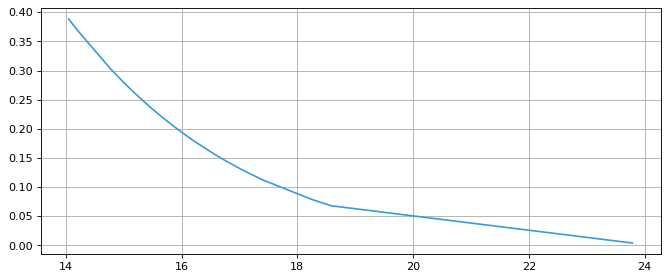

In [24]:
plt.figure(figsize=(10, 4), dpi=80)
data = sorted(extremes.values)
plt.plot(data, distribution.pdf(data), color='#379BDB')
plt.grid(True)
plt.show()
plt.close()

In [25]:
# 5. Вычисляем score как RiskScore от neg_log_prob (здесь скор - это вероятность)
probs = distribution.cdf(neg_log_prob)
print(len(probs))
print(probs)

328782
[0. 0. 0. ... 0. 0. 0.]


In [26]:
# 6. Вычисляем prediction как inverse_transform от scaled_prediction.
prediction = collection['scaler'].inverse_transform(scaled_prediction)
print(prediction.shape)

(328782, 8)


In [27]:
neg_log_probs = pd.Series(data=neg_log_prob, index=df_metrics.index)
print(neg_log_probs.shape)

(328782,)


In [28]:
extremes = neg_log_probs[neg_log_probs > threshold]
print(len(extremes))

58624


In [29]:
threshold_new = np.percentile(neg_log_prob, percentile_th)
print('threshold_new:', threshold_new)
extremes = neg_log_probs[neg_log_probs > threshold_new]
print(len(extremes))

threshold_new: 76.62897690584097
99


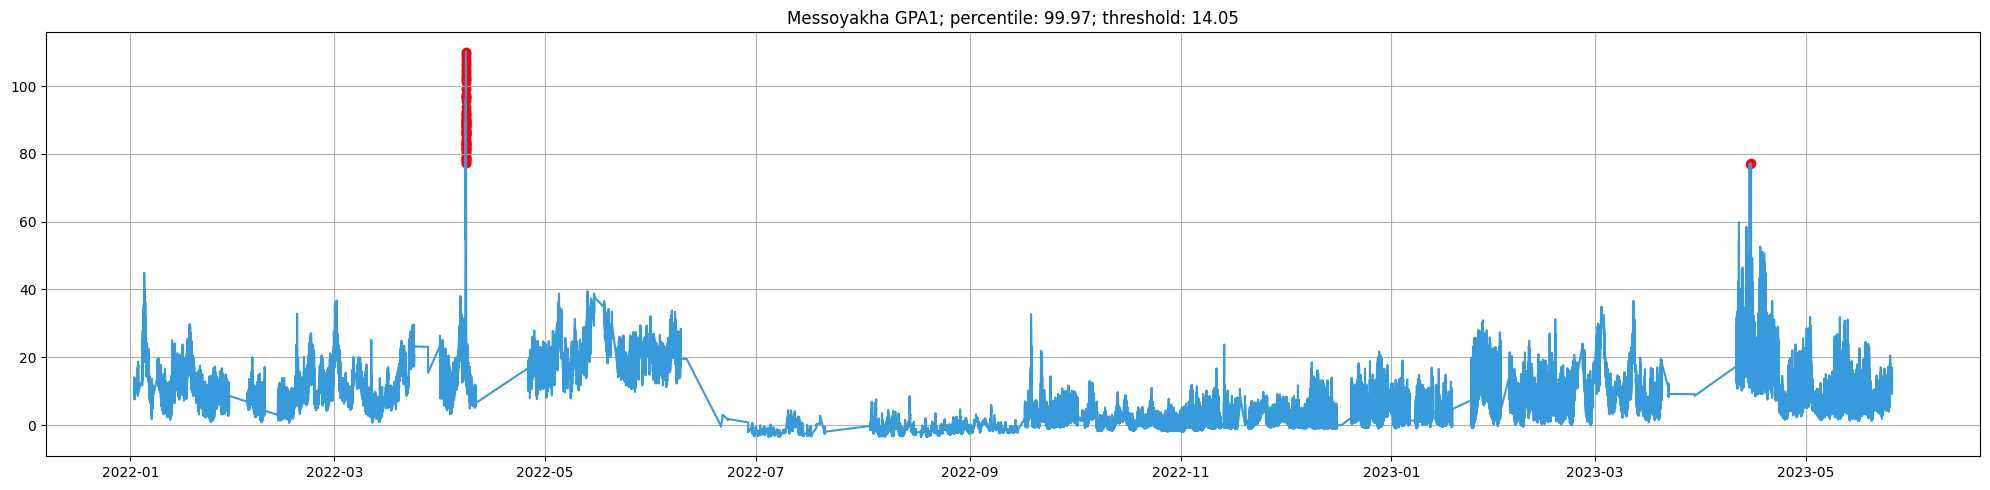

In [30]:
plt.figure(figsize=(20, 5))
plt.plot(neg_log_probs, color='#379BDB')
plt.scatter(extremes.index, extremes.values, color='red')
plt.grid(True)
plt.title('{} {}; percentile: {}; threshold: {}'.format(COMPANY, EQUIPMENT, percentile_th, round(threshold, 2)))
plt.tight_layout()
plt.savefig(os.path.join(data_path_models, model_replacer[model_name], 'anomaly_by_neg_log_prob.png'))
plt.show()
plt.close()

In [19]:
print([col for col in metadata['labels'] if col not in sys_dict[model_name]])
print([col for col in sys_dict[model_name] if col not in metadata['labels']])

['171', '182']
['140', '215']


In [87]:
score = pd.read_parquet(os.path.join(save_path, 'score.parquet'))
print(score.shape)
exp = pd.read_parquet(os.path.join(save_path, 'explanation.parquet'))
print(exp.shape)
prediction = pd.read_parquet(os.path.join(save_path, 'prediction.parquet'))
print(prediction.shape)

(341425, 1)
(341425, 47)
(341425, 47)


In [82]:
result = model.get_prediction(df_metrics_raw[sys_dict[model_name]])
score = pd.DataFrame(result['anomaly_score'], index=df_metrics_raw.index, columns=['0'])
print(score.shape)
exp = pd.DataFrame(result['explanation'], index=df_metrics_raw.index, columns=sys_dict[model_name])
print(exp.shape)
prediction = pd.DataFrame(result['prediction'], index=df_metrics_raw.index, columns=sys_dict[model_name])
print(prediction.shape)

(341425, 1)
(341425, 47)
(341425, 47)


In [83]:
score.to_parquet(os.path.join(save_path, 'score.parquet'))
print(score.shape)
exp.to_parquet(os.path.join(save_path, 'explanation.parquet'))
print(exp.shape)
prediction.to_parquet(os.path.join(save_path, 'prediction.parquet'))
print(prediction.shape)

(341425, 1)
(341425, 47)
(341425, 47)


#### Подготовка данных

In [ ]:
print(EQUIPMENT)

for model_name in model_names:
    save_path = os.path.join(data_path, fr'models\Обученные модели\К{EQUIPMENT_NUM}', model_replacer[model_name])
    model = ModelInference(os.path.join(save_path, 'model_2022.pkl'), threshold=99.7)
    metadata = model.meta
    result = model.get_prediction(df_metrics_raw[metadata['labels']])
    score = pd.DataFrame(result['anomaly_score'], index=df_metrics_raw.index, columns=['0'])
    score.to_parquet(os.path.join(save_path, 'score.parquet'))
    exp = pd.DataFrame(result['explanation'], index=df_metrics_raw.index, columns=metadata['labels'])
    exp.to_parquet(os.path.join(save_path, 'explanation.parquet'))
    prediction = pd.DataFrame(result['prediction'], index=df_metrics_raw.index, columns=metadata['labels'])
    prediction.to_parquet(os.path.join(save_path, 'prediction.parquet'))
    print(model_name, len(metadata['labels']), prediction.shape)

In [16]:
df_inference = pd.DataFrame()

for model_name in model_names:
#for model_name in ['DGS_V1']:
    #file_path = os.path.join(data_path, 'models', EQUIPMENT, model_name, 'score.parquet')
    file_path = os.path.join(data_path, fr'models\Обученные модели\К{EQUIPMENT_NUM}', model_replacer[model_name], 
                             'score.parquet')
    if os.path.isfile(file_path):
        score = pd.read_parquet(file_path)
        mask_inference = (~mask_stops) & (score['0'] > 0.25)
        #mask_inference = (~mask_stops) & (score['0'] > 0.25) & (df_metrics_raw['6'] > 0)
        #mask_inference = (df_metrics_raw['6'] > 0)
        df_inference_tmp = score[mask_inference == True]
        df_inference_tmp.rename(columns={'0': 'score'}, inplace=True)
        df_inference_tmp['model_name'] = model_name
        df_inference_tmp.reset_index(inplace=True)
        df_inference = pd.concat([df_inference, df_inference_tmp])
        print(model_name, df_inference_tmp.shape[0])

df_inference.sort_values(by=['DateTime', 'model_name'], ascending=[True, True], inplace=True)
print(df_inference.shape)
df_inference.head(3)

GT_V1 17692
GT_V2 17107
GT_MECH_V1 13436
COMP_GAS_V1 6502
COMP_GAS_V2 5029
COMP_GAS_V3 4278
COMP_MECH_V1 7853
COMP_MECH_V2 6138
MULTIPLICATOR_V1 3555
DGS_V1 1590
(83180, 3)


,DateTime,score,model_name
0,2020-01-28 18:48:33,0.932031,COMP_GAS_V1
0,2020-01-28 18:48:33,0.772229,COMP_MECH_V1
0,2020-01-28 18:48:33,0.278007,COMP_MECH_V2


In [17]:
df_inference_grp = df_inference.groupby(['DateTime']).agg(score_min=(pd.NamedAgg(column='score', aggfunc=min)),
                                                          score_max=(pd.NamedAgg(column='score', aggfunc=max)),
                                                          model_names=(pd.NamedAgg(column='model_name', aggfunc=list)))
df_inference_grp.reset_index(inplace=True)
print(df_inference_grp.shape)
df_inference_grp.head(3)

(24505, 4)


,DateTime,score_min,score_max,model_names
0,2020-01-28 18:48:33,0.278007,0.932031,"[COMP_GAS_V1, COMP_MECH_V1, COMP_MECH_V2]"
1,2020-01-28 18:53:33,0.589658,0.935832,"[COMP_GAS_V1, COMP_GAS_V2, COMP_MECH_V1]"
2,2020-01-28 18:58:33,0.739182,0.931154,"[COMP_GAS_V1, COMP_MECH_V1]"


In [18]:
%%time
df_inference_grp['Номер'] = -1

for idx, row in df_inference_grp.iterrows():
    mask = (row['DateTime'] > df_shutdown['время  запуска пред.']) & (row['DateTime'] < df_shutdown['время остановки'])
    if sum(mask) > 0:
        df_inference_grp.loc[idx, 'Номер'] = df_shutdown.loc[mask, 'Номер'].values[0]

CPU times: total: 9.36 s
Wall time: 10.7 s


In [19]:
df_inference_grp = pd.merge(left=df_inference_grp, 
                            right=df_shutdown[['Номер', 'время остановки', 'время  запуска', 
                                               'параметр остановки компрессорной установки', 'причина остановки']], 
                            how='left', 
                            left_on=['Номер'], 
                            right_on=['Номер'])

df_inference_grp['delta'] = (df_inference_grp['время остановки'] - df_inference_grp['DateTime']) / pd.offsets.Day(1)
df_inference_grp.to_excel(os.path.join(data_path, fr"models\df_inference_grp_all_К{EQUIPMENT_NUM}.xlsx"),
                          sheet_name='Detail',
                          index=False)
print(df_inference_grp.shape)

(24505, 10)


In [20]:
df_inference_grp = pd.read_excel(os.path.join(data_path, fr"models\df_inference_grp_all_К{EQUIPMENT_NUM}.xlsx"))
df_inference_grp.sort_values(by=['DateTime'], ascending=[True], inplace=True)

df_inference_grp.rename(columns={'DateTime':'DateTime_from'}, inplace=True)
df_inference_grp['DateTime_next'] = df_inference_grp['DateTime_from'].shift(-1)
df_inference_grp['delta_mi'] = (df_inference_grp['DateTime_next'] - df_inference_grp['DateTime_from']) / pd.Timedelta(minutes=1)
df_inference_grp['delta_mi_prev'] = df_inference_grp['delta_mi'].shift(1)
df_inference_grp['delta_mi_next'] = df_inference_grp['delta_mi'].shift(-1)
mask_contiguous = ((df_inference_grp['delta_mi'] <= delta_mi_max) & 
                   (df_inference_grp['delta_mi_prev'] <= delta_mi_max) &
                   (df_inference_grp['delta_mi_next'] <= delta_mi_max))
df_inference_grp = df_inference_grp[~mask_contiguous].copy()
df_inference_grp = df_inference_grp[df_inference_grp['delta_mi'] <= delta_mi_max].copy()
df_inference_grp['DateTime_to'] = df_inference_grp['DateTime_next'].shift(-1)
df_inference_grp = df_inference_grp[df_inference_grp['delta_mi_next'] <= delta_mi_max].copy()
df_inference_grp['delta_h'] = (df_inference_grp['DateTime_to'] - df_inference_grp['DateTime_from']) / pd.Timedelta(hours=1)
df_inference_grp['delta_days'] = (df_inference_grp['время остановки'] - df_inference_grp['DateTime_to']) / pd.offsets.Day(1)

print(df_inference_grp.shape)

(429, 17)


In [21]:
#df_inference_grp[['DateTime_from', 'DateTime_to', 'delta_h', 'delta_mi_prev', 'delta_mi', 'delta_mi_next']].head(30)
df_inference_grp = df_inference_grp[['DateTime_from', 'DateTime_to', 'delta_h', 'model_names', 'Номер', 'delta_days',
                                     'время остановки', 'время  запуска', 'параметр остановки компрессорной установки', 
                                     'причина остановки']]
#df_inference_grp = df_inference_grp[['DateTime_from', 'DateTime_to', 'delta_h', 'model_names', 'Номер']]
df_inference_grp.to_excel(os.path.join(data_path, fr"models\df_inference_interval_К{EQUIPMENT_NUM}.xlsx"), 
                          sheet_name='Interval',
                          index=False)

In [20]:
df_tmp = df_metrics_raw.loc[pd.to_datetime('21.11.2022  13:19', dayfirst=True):pd.to_datetime('22.11.2022  22:04', dayfirst=True), 
                            mode_tag]
#df_tmp = df_metrics_raw[~mask_stops]
#df_tmp = df_tmp.loc[pd.to_datetime('01.03.2023 00:00', dayfirst=True):pd.to_datetime('02.03.2023 00:00', dayfirst=True), 
#                    mode_tag]
df_tmp

DateTime
2022-11-21 13:19:00   NaN
2022-11-21 13:24:00   NaN
2022-11-21 13:29:00   NaN
2022-11-21 13:34:00   NaN
2022-11-21 13:39:00   NaN
                       ..
2022-11-22 21:44:00   NaN
2022-11-22 21:49:00   NaN
2022-11-22 21:54:00   NaN
2022-11-22 21:59:00   NaN
2022-11-22 22:04:00   NaN
Name: 137, Length: 394, dtype: float64

In [127]:
df_tmp.to_excel(os.path.join(data_path, r"models\df_tmp.xlsx"))

In [78]:
#score.loc[start_pos:end_pos]

#### Визуализация

In [22]:
df_inference_grp = pd.read_excel(os.path.join(data_path, fr"models\df_inference_grp_all_К{EQUIPMENT_NUM}.xlsx"),
                                 sheet_name='Detail_0.997_0.25')
print(df_inference_grp.shape)
print(df_metrics_raw.loc[(~mask_stops)].shape)

(24505, 10)
(233306, 432)


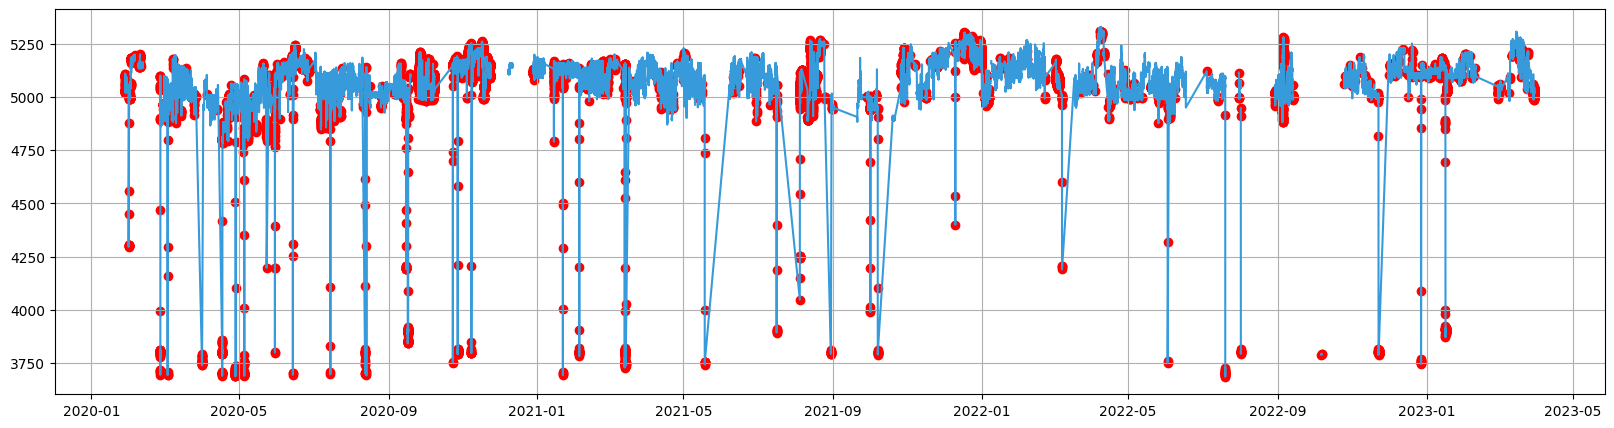

In [23]:
plt.figure(figsize=(20, 5))
#plt.plot(df_metrics_raw[mode_tag], color='#379BDB')
plt.plot(df_metrics_raw.loc[(~mask_stops), mode_tag], color='#379BDB')
plt.scatter(df_inference_grp['DateTime'], df_metrics_raw.loc[df_inference_grp['DateTime'], mode_tag], color='red')
plt.grid(True)
plt.show()
plt.close()

##### GPA1

In [10]:
model_name = 'FLOWPATH_v7'
percentile_th = 99.7 # μ ± 3.5σ = 0.9995
print(model_name, percentile_th)
save_path = os.path.join(data_path, fr'models\{EQUIPMENT}{suffix}', model_replacer[model_name])
print(save_path)
model = ModelInferenceOld(os.path.join(save_path, 'model.pkl'), threshold=percentile_th)
#model = ModelInference(os.path.join(save_path, 'model.pkl'), upper_bound=percentile_th)
metadata = model.meta
print(len(metadata['labels']))

smooth_n = 60*24
df_metrics_s = df_metrics[metadata['labels']].rolling(smooth_n).mean()
df_metrics_s = df_metrics_s[smooth_n-1:]

data = df_metrics #_s #_raw
print(data.shape)

result = model.get_prediction(data[metadata['labels']])
score = pd.DataFrame(result['anomaly_score'], index=data.index, columns=['0'])
print(score.shape)
exp = pd.DataFrame(result['explanation'], index=data.index, columns=metadata['labels'])
print(exp.shape)
prediction = pd.DataFrame(result['prediction'], index=data.index, columns=metadata['labels'])
print(prediction.shape)

FLOWPATH_v7 99.7
C:\Users\User\Documents\TASKS\PEGAZ\datasets\Messoyakha\models\GPA1\Проточная часть 7
8
(328782, 244)
(328782, 1)
(328782, 8)
(328782, 8)


In [39]:
print(score[score['0'] == 0.0].shape)
print(score[(score['0'] > 0.5) & (score['0'] < 1.0)].shape)
print(score[score['0'] == 1.0].shape)
print(score['0'].min(), score['0'].max())

(225729, 1)
(87559, 1)
(0, 1)
0.0 0.9999999999843574


In [64]:
score.to_parquet(os.path.join(save_path, 'score.parquet'))
exp.to_parquet(os.path.join(save_path, 'explanation.parquet'))
prediction.to_parquet(os.path.join(save_path, 'prediction.parquet'))

In [109]:
#start_date = '01.09.2022 00:00:00'
#end_date = '01.10.2022 00:00:00'
start_date = '02.10.2022 00:00:00'
end_date = '09.04.2023 00:00:00'

start_pos = pd.to_datetime(start_date, dayfirst=True)
end_pos = pd.to_datetime(end_date, dayfirst=True)
interval = (start_pos, end_pos)

plot_anomaly(score['0'], 
             exp.rename(columns=replacer),
             data.rename(columns=replacer),
             prediction.rename(columns=replacer),
             interval, 
             limit=0.5, 
             top=10, 
             figsize=(20,30),
             save=data_path_processed,
             suptitle=None, 
             ylim=1)

##### GPA2

In [47]:
model_name = 'DGS_V1'
print(model_name)
#save_path = os.path.join(data_path, 'models', EQUIPMENT, model_name)
#save_path = os.path.join(data_path, fr'models\Газпромнефть-Оренбург\К{EQUIPMENT_NUM}', model_replacer[model_name])
save_path = os.path.join(data_path, fr'models\Обученные модели\К{EQUIPMENT_NUM}', model_replacer[model_name])
print(save_path)
#model = ModelInference(os.path.join(save_path, 'model_2022.pkl'), threshold=95)
model = ModelInference(os.path.join(save_path, 'model_2022.pkl'), threshold=99.7)
metadata = json.loads(model.meta)
print(len(metadata['labels']))

result = model.get_prediction(df_metrics_raw[metadata['labels']])
score = pd.DataFrame(result['anomaly_score'], index=df_metrics_raw.index, columns=['0'])
print(score.shape)
exp = pd.DataFrame(result['explanation'], index=df_metrics_raw.index, columns=metadata['labels'])
print(exp.shape)
prediction = pd.DataFrame(result['prediction'], index=df_metrics_raw.index, columns=metadata['labels'])
print(prediction.shape)

DGS_V1
C:\Users\User\Documents\TASKS\PEGAZ\datasets\Orenburg\models\Обученные модели\К4\СГУ
9
(315588, 1)
(315588, 9)
(315588, 9)


<b>K4. 1. Низкое давление топливного газа  по причине самопроизвольного закрытия отсекателя</b> \
В модели GT_V2 срабатывает тег 170. Р ВОЗД ЗА КОМПРЕС ВД. \
Алармит об аномалиях, и дефект на самом деле есть, но связи с описанным кейсом нет. \
start_date = '04.02.2021  13:18' # 10.02.2021  22:22 \
end_date = '10.02.2021  23:22' # 10.02.2021  23:22

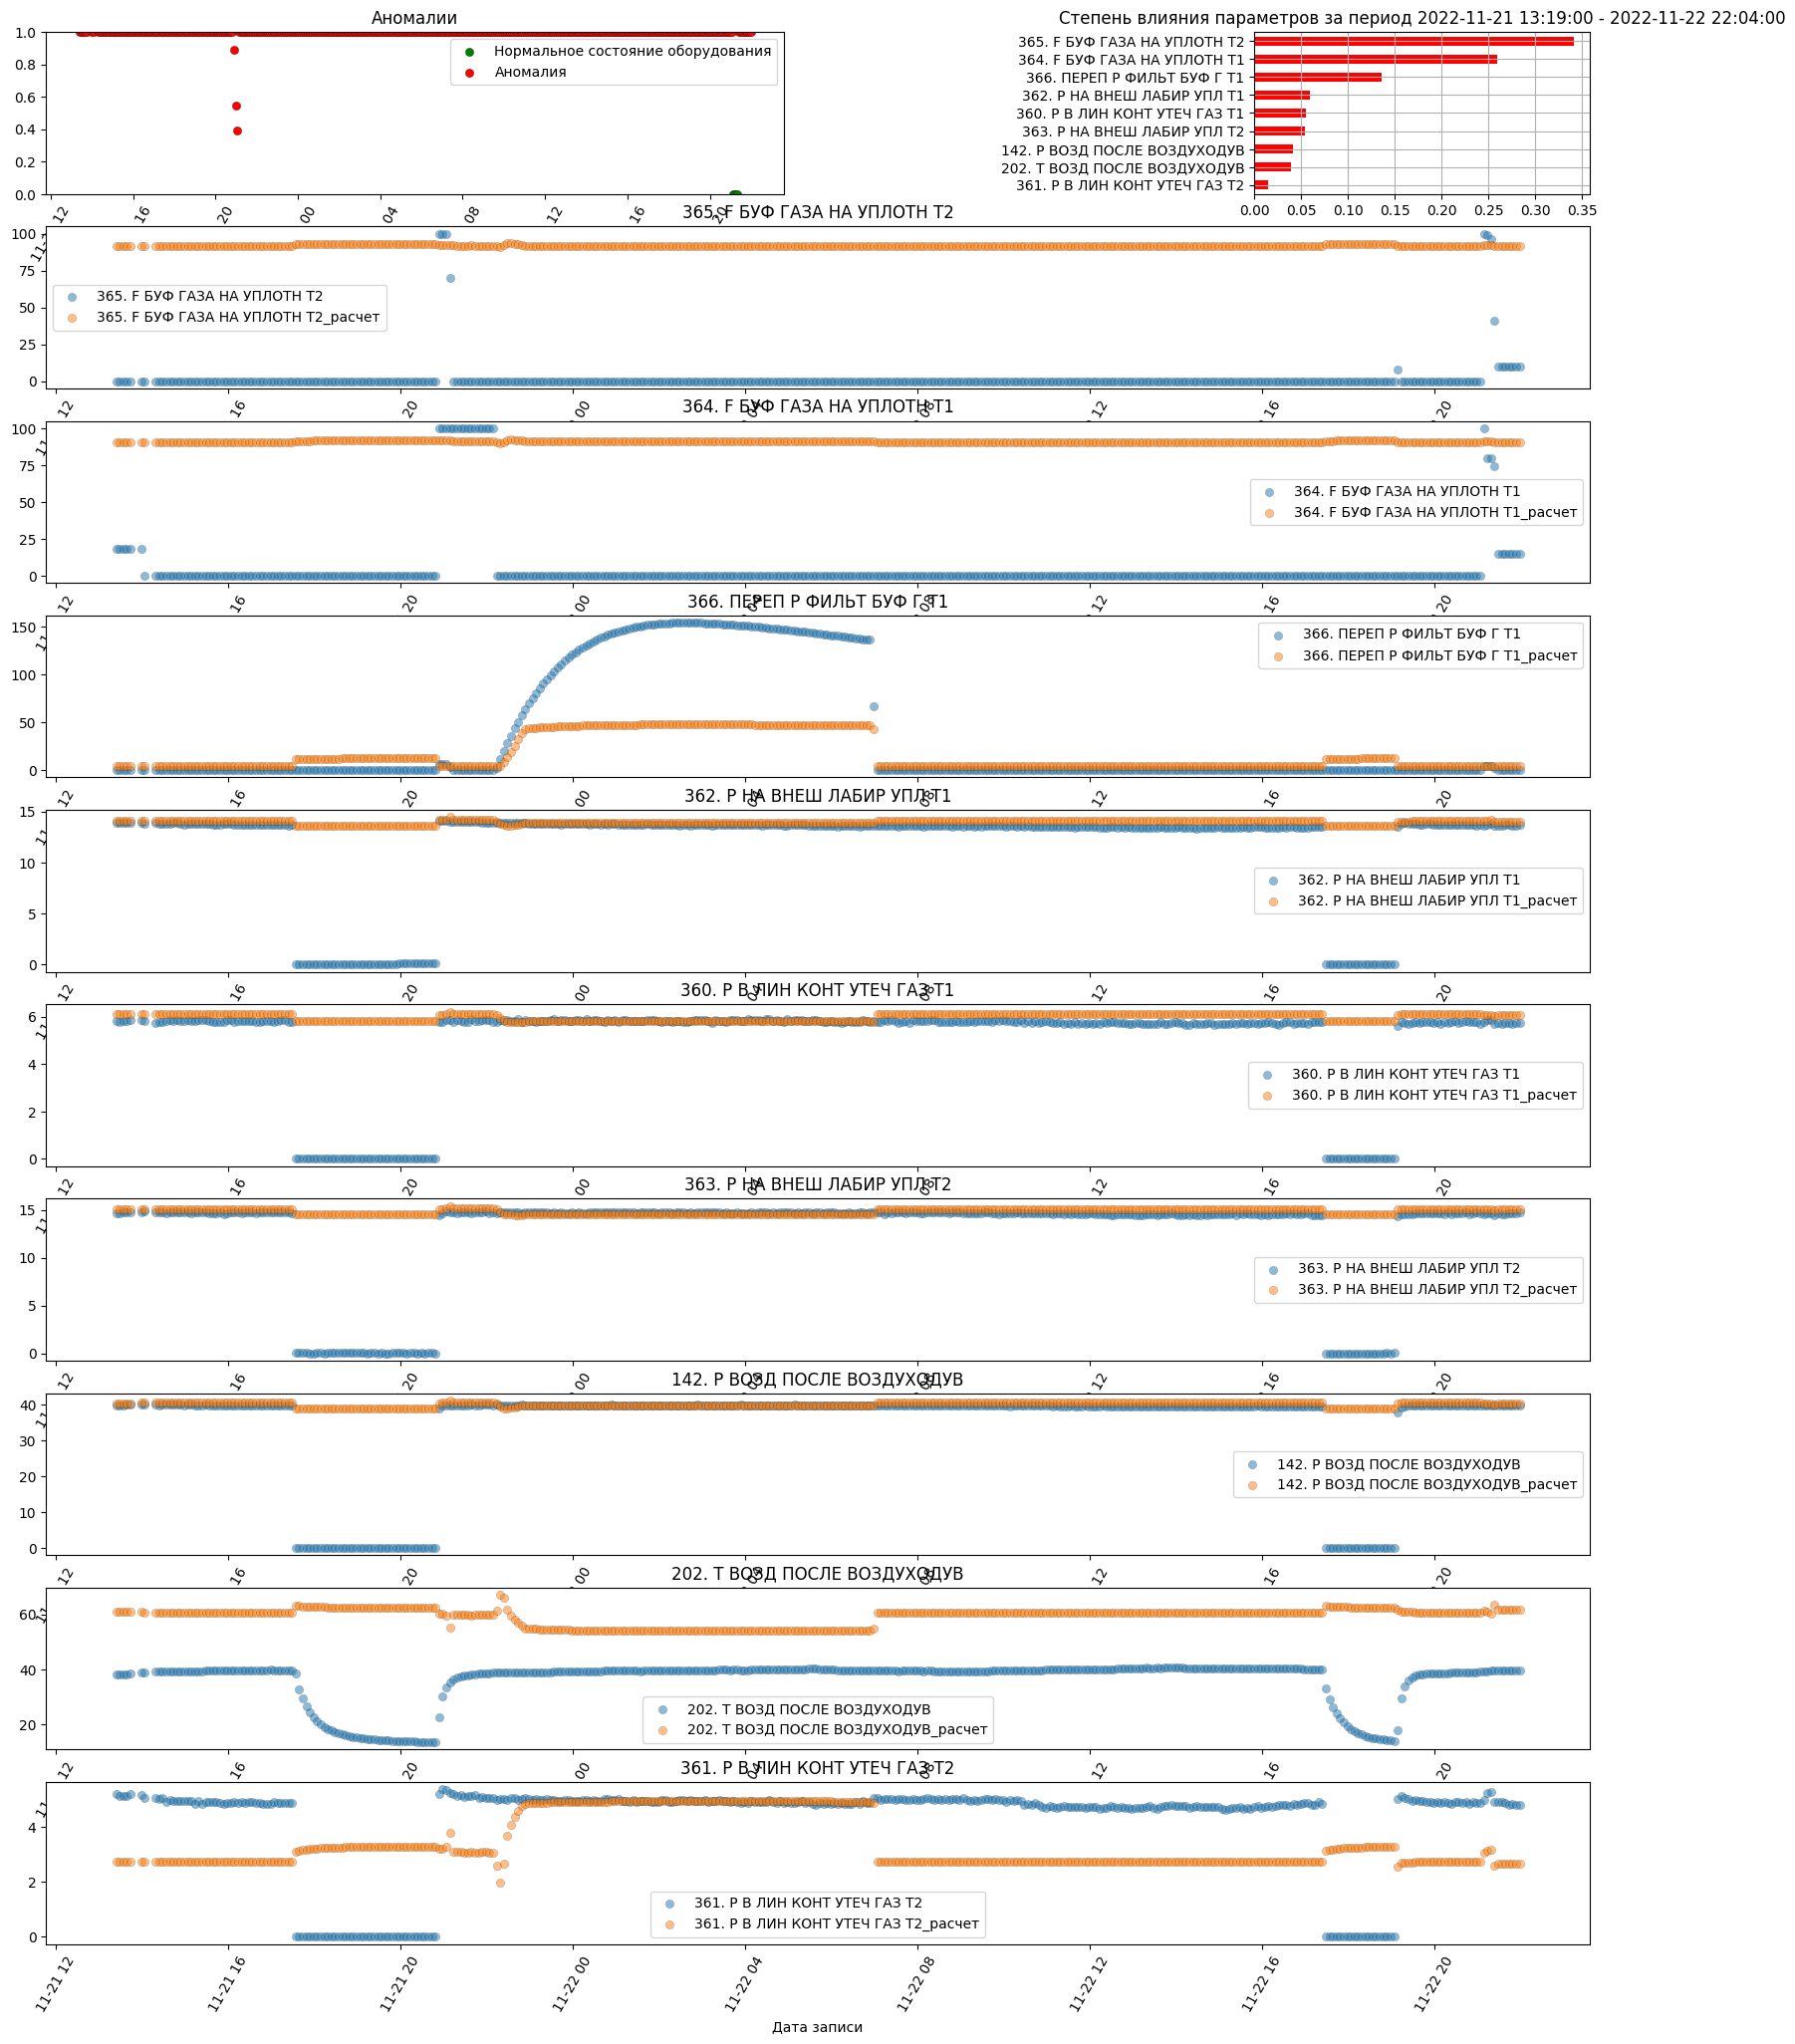

In [48]:
start_date = '21.11.2022  13:19' # 11.08.2022 12:20
end_date = '22.11.2022  22:04' # 11.08.2022 13:10

start_pos = pd.to_datetime(start_date, dayfirst=True)
end_pos = pd.to_datetime(end_date, dayfirst=True)
interval = (start_pos, end_pos)

plot_anomaly(score['0'], 
             exp.rename(columns=replacer),
             df_metrics_raw.rename(columns=replacer),
             prediction.rename(columns=replacer),
             interval, 
             limit=0.25, 
             top=10, 
             figsize=(20,30),
             suptitle=None, 
             ylim=1)

147 ОПАСНОЕ Р РТ ВХ


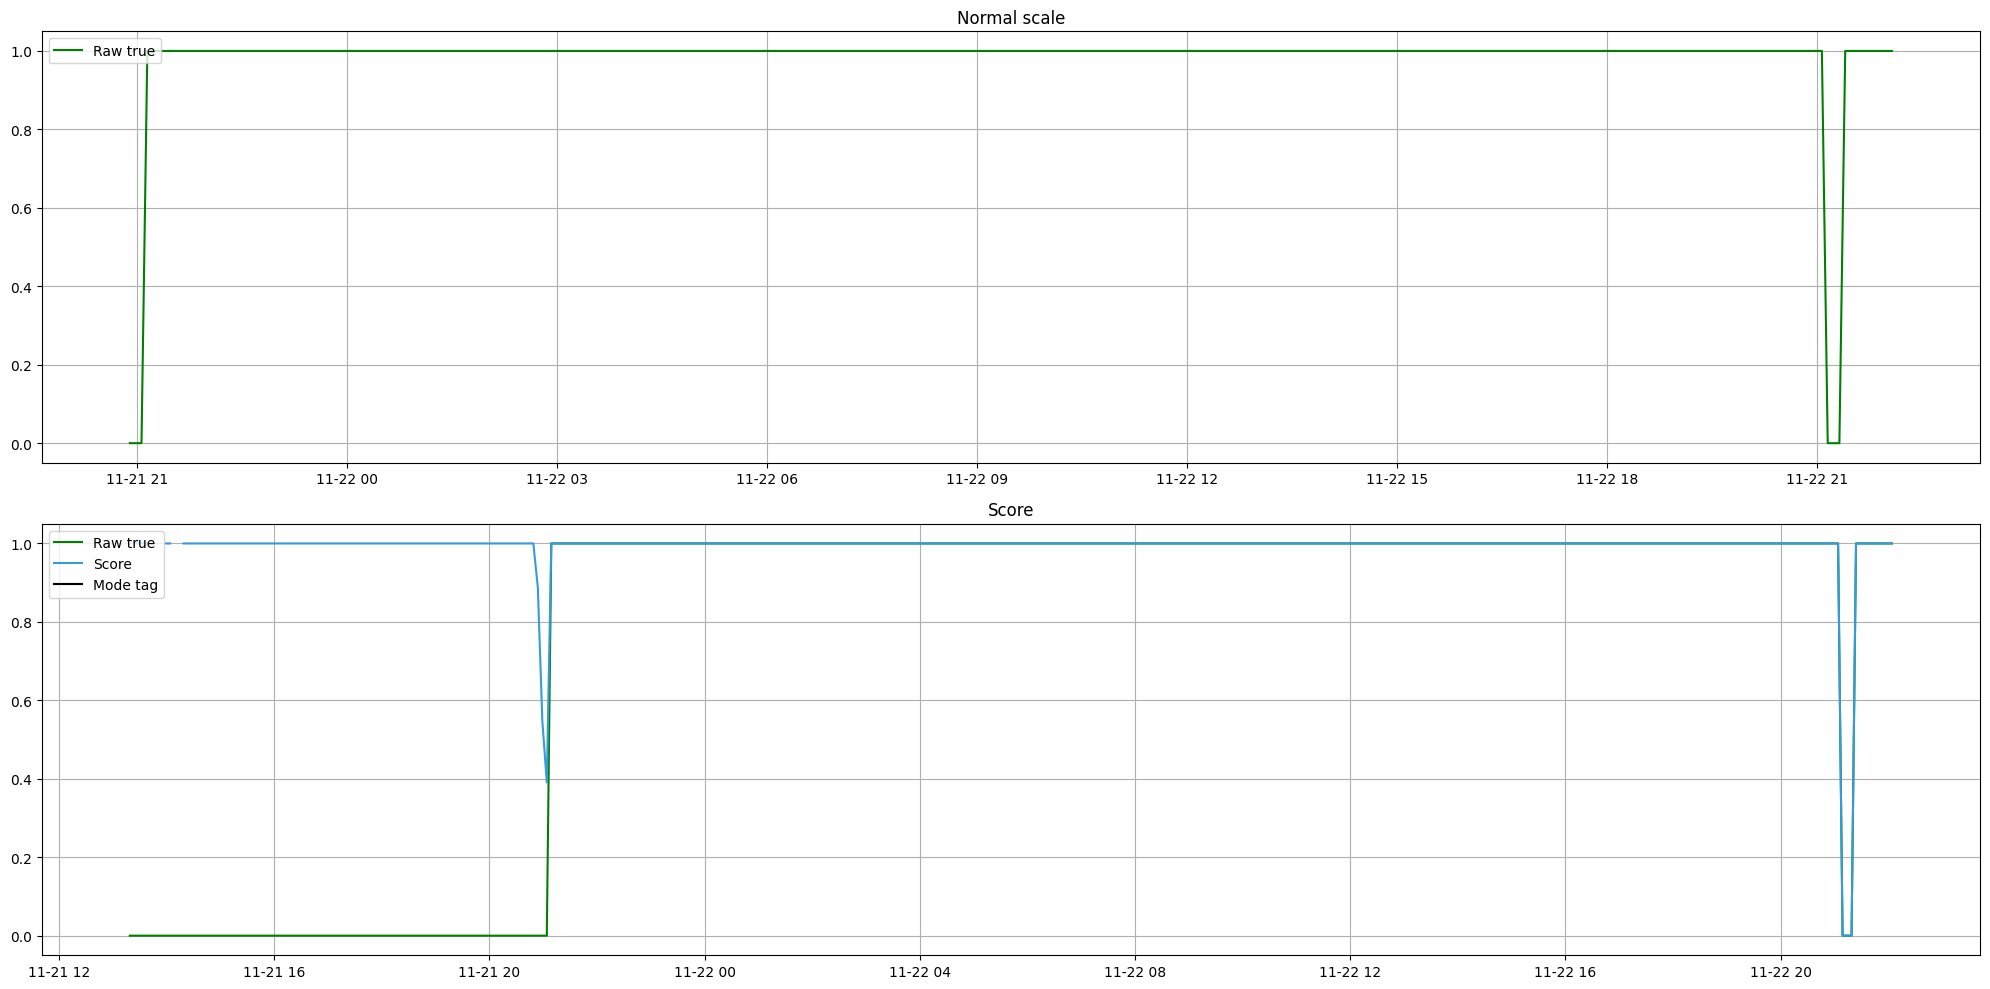

In [49]:
plot_anomaly3('147', start_date, end_date, show_prediction=False)

##### Графики всех тегов модели

FLOWPATH_v7 8


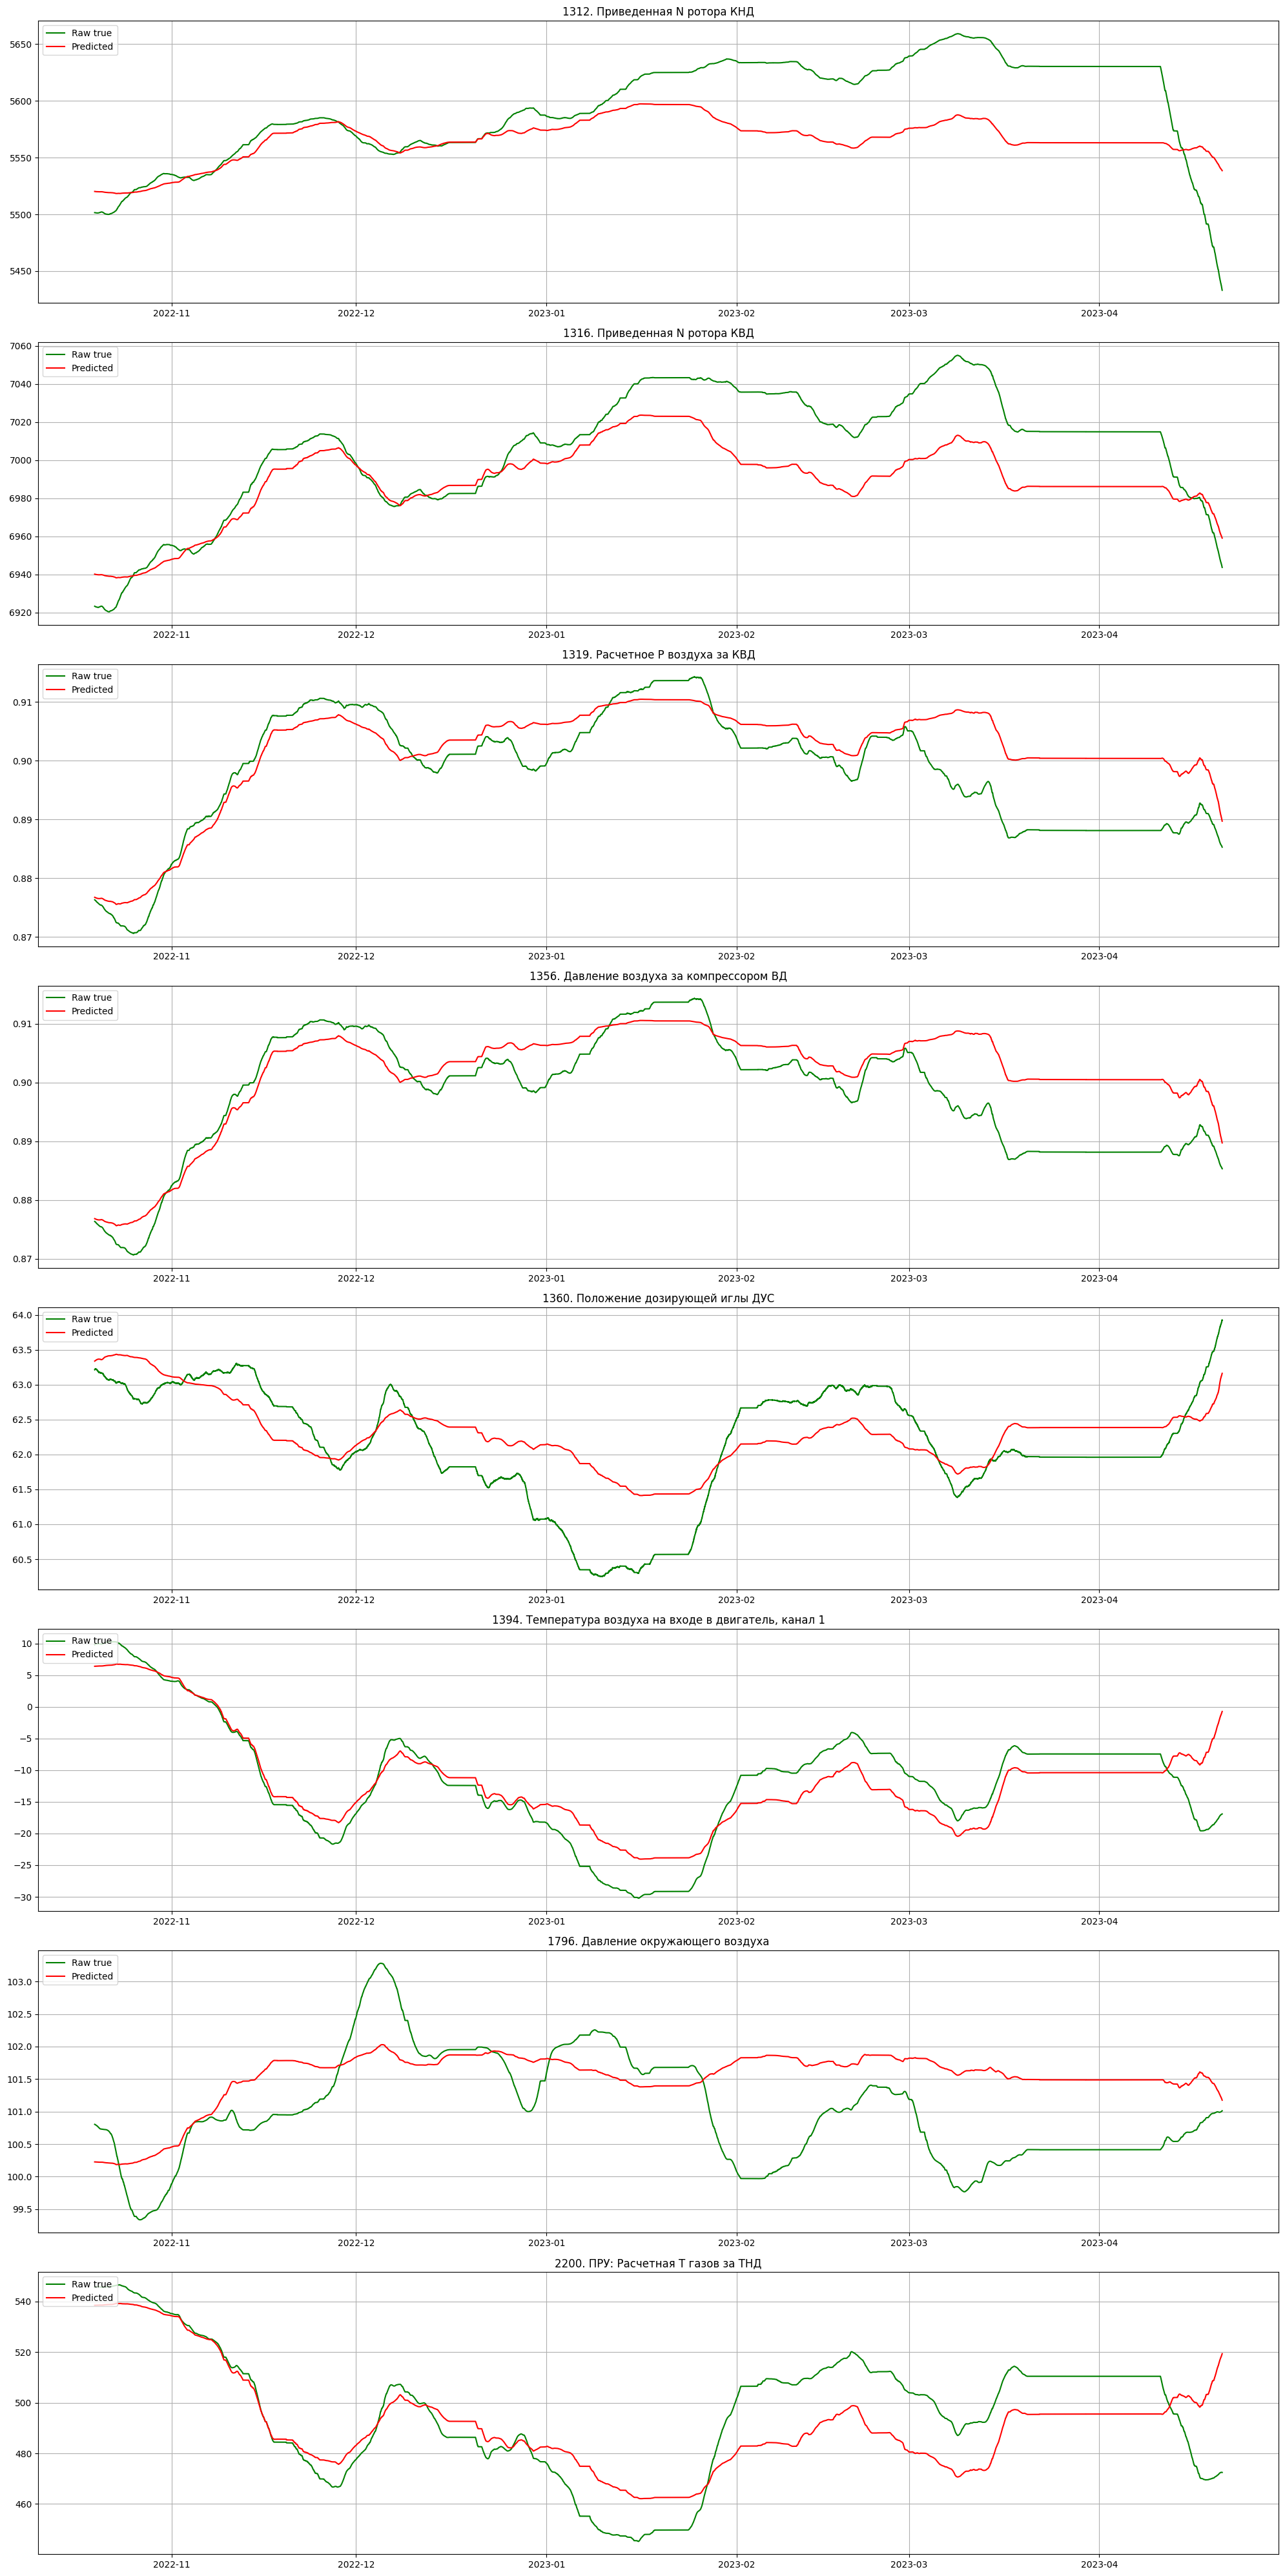

In [27]:
start_date = '09.10.2022 00:00:00' #'19.06.2022 00:00:00' #
end_date = '21.04.2023 00:00:00' #'01.10.2022 00:00:00' #

cols = metadata['labels'] # sys_dict[model_name]
n = len(cols)
print(model_name, n)
plot_anomaly2(df_true=df_metrics, #_s, 
              df_pred=prediction, 
              tag_list=cols, 
              start_date=start_date, 
              end_date=end_date, 
              smooth_n=60*24*7, 
              save_path=os.path.join(data_path_models, model_replacer[model_name], model_name+'_weekly'))

##### Скоры

FLOWPATH_v7


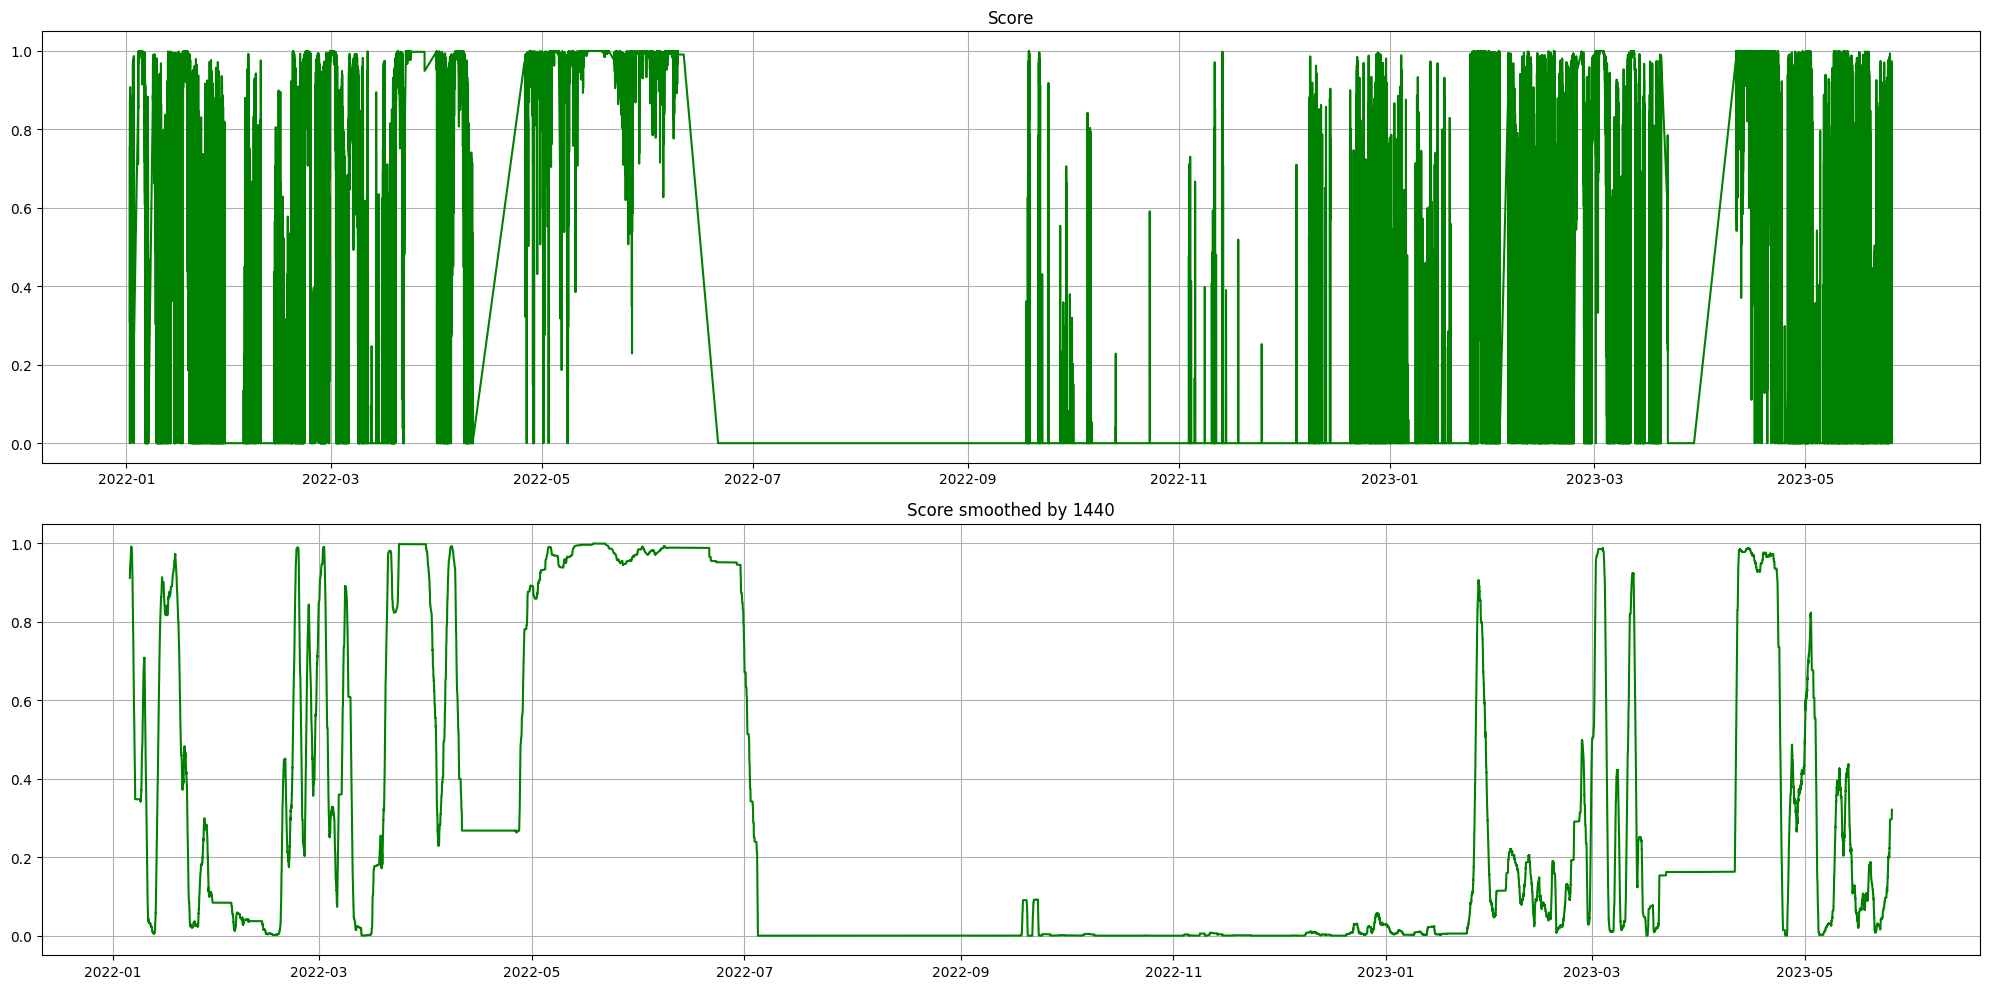

In [12]:
start_date = '02.01.2022 00:00' 
end_date = '25.05.2023 23:33'

print(model_name)
plot_score(df_score=score, 
           start_date=start_date, 
           end_date=end_date, 
           smooth_n=60*24*1) #,
           #save_path=os.path.join(data_path_models, model_replacer[model_name], model_name+'_score'))

In [13]:
start_pos = pd.to_datetime(start_date, dayfirst=True)
end_pos = pd.to_datetime(end_date, dayfirst=True)

smooth_n = 0 #60*24*1
score_tmp = score.loc[start_pos:end_pos, :].copy()
score_s = score_tmp.rolling(smooth_n).mean()
score_s = score_s[smooth_n-1:]

In [19]:
info_th = 0.25
warn_th = 0.50
anomaly_th = 0.75
freq='5D'
df_periods = pd.DataFrame()

score_tmp = score.loc[start_pos:end_pos, :]
#score_tmp = score_s.loc[start_pos:end_pos, :]
print(score_tmp.shape)
print('Normal:', score_tmp[(score_tmp['0'] <= info_th)].shape)
print('Info:', score_tmp[(score_tmp['0'] > info_th) & (score_tmp['0'] <= warn_th)].shape)
print('Warn:', score_tmp[(score_tmp['0'] > warn_th) & (score_tmp['0'] <= anomaly_th)].shape)
print('Anomaly:', score_tmp[(score_tmp['0'] > anomaly_th)].shape)

periods = pd.period_range(start=score_tmp.index.min(), 
                          end=score_tmp.index.max(),
                          freq=freq)
for i, _ in enumerate(periods):
    if freq == 'M':
        period_name = periods[i].strftime('%Y-%m')
        score_tmp1 = score_tmp[period_name]
    else:
        period_name = periods[i].strftime('%Y-%m-%d')
        try:
            score_tmp1 = score_tmp.loc[(score_tmp.index >= periods[i].to_timestamp()) & 
                                       (score_tmp.index < periods[i+1].to_timestamp())]
        except IndexError:
            score_tmp1 = score_tmp.loc[(score_tmp.index >= periods[i].to_timestamp())]
    
    normal_cnt = score_tmp1[(score_tmp1['0'] <= info_th)].shape[0]
    info_cnt = score_tmp1[(score_tmp1['0'] > info_th) & (score_tmp1['0'] <= warn_th)].shape[0]
    warn_cnt = score_tmp1[(score_tmp1['0'] > warn_th) & (score_tmp1['0'] <= anomaly_th)].shape[0]
    anomaly_cnt = score_tmp1[(score_tmp1['0'] > anomaly_th)].shape[0]
    divergence_cnt = info_cnt + warn_cnt + anomaly_cnt
    anomaly_pct = 0 if score_tmp1.shape[0] == 0 else anomaly_cnt / score_tmp1.shape[0]
    anomaly_pct2 = 0 if divergence_cnt == 0 else anomaly_cnt / divergence_cnt
    #print(period_name, score_tmp1.shape[0], anomaly_cnt, anomaly_pct, anomaly_pct2)
    
    frame = {'period': period_name,
             'all_cnt': score_tmp1.shape[0],
             'normal_cnt': normal_cnt,
             'info_cnt': info_cnt,
             'warn_cnt': warn_cnt,
             'anomaly_cnt': anomaly_cnt,
             'anomaly_pct': anomaly_pct,
             'anomaly_pct2': anomaly_pct2
            }
    
    df_periods = df_periods.append(pd.DataFrame(data=frame, dtype=object, index=[i]))

df_periods.to_excel(os.path.join(data_path_models, model_replacer[model_name], r"df_periods.xlsx"), 
                    sheet_name=str(freq),
                    index=False)
print(df_periods.shape)

(328782, 1)
Normal: (232480, 1)
Info: (8743, 1)
Warn: (13095, 1)
Anomaly: (74464, 1)
(102, 8)


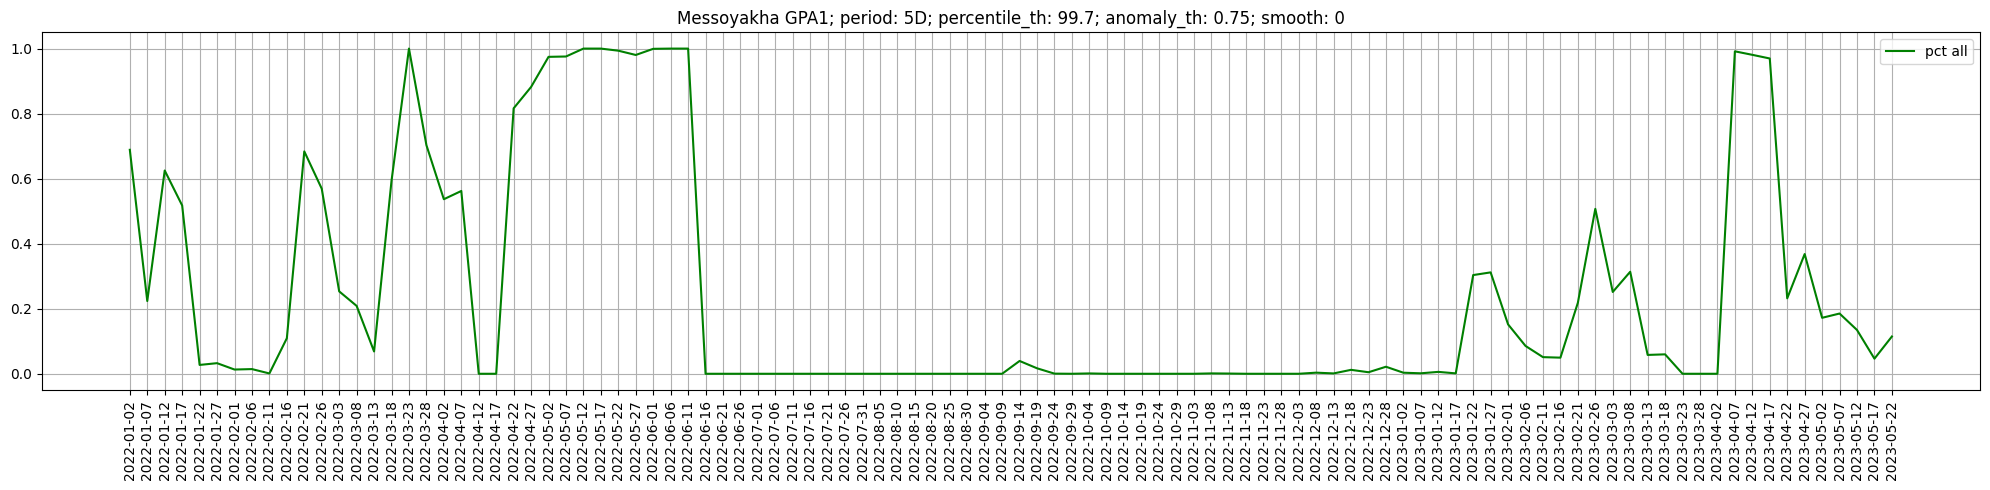

In [20]:
file_name = '{}_{}_{}_{}_{}_{}.png'.format(COMPANY, EQUIPMENT, freq, percentile_th, anomaly_th, smooth_n)
plt.figure(figsize=(20, 5))
plt.plot(df_periods['period'], df_periods['anomaly_pct'], color='g', label='pct all')
#plt.plot(df_periods['period'], df_periods['anomaly_pct2'], color='#379BDB', label='pct divergence')
plt.grid(True)
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.title('{} {}; period: {}; percentile_th: {}; anomaly_th: {}; smooth: {}'.format(COMPANY, 
                                                                                    EQUIPMENT, 
                                                                                    freq, 
                                                                                    percentile_th,
                                                                                    anomaly_th, 
                                                                                    smooth_n))
plt.tight_layout()
plt.savefig(os.path.join(data_path_models, model_replacer[model_name], file_name))
plt.show()
plt.close()

**Sliding window approach test**

In [23]:
info_th = 0.25
warn_th = 0.50
anomaly_th = 0.75
freq='5D'
df_periods = score.loc[start_pos:end_pos, :]
print(df_periods.shape)
print('Normal:', df_periods[(df_periods['0'] <= info_th)].shape)
print('Info:', df_periods[(df_periods['0'] > info_th) & (df_periods['0'] <= warn_th)].shape)
print('Warn:', df_periods[(df_periods['0'] > warn_th) & (df_periods['0'] <= anomaly_th)].shape)
print('Anomaly:', df_periods[(df_periods['0'] > anomaly_th)].shape)

df_periods['all_cnt'] = 1
df_periods['normal_cnt'] = 0
df_periods.loc[(df_periods['0'] <= info_th), 'normal_cnt'] = 1
df_periods['info_cnt'] = 0
df_periods.loc[(df_periods['0'] > info_th) & (df_periods['0'] <= warn_th), 'info_cnt'] = 1
df_periods['warn_cnt'] = 0
df_periods.loc[(df_periods['0'] > warn_th) & (df_periods['0'] <= anomaly_th), 'warn_cnt'] = 1
df_periods['anomaly_cnt'] = 0
df_periods.loc[(df_periods['0'] > anomaly_th), 'anomaly_cnt'] = 1

print(df_periods.shape)

df_periods_grp = (df_periods[['all_cnt', 'normal_cnt', 'info_cnt', 'warn_cnt', 'anomaly_cnt']]
                  .groupby(pd.DatetimeIndex(df_periods.index).date)
                  .agg(all_cnt=pd.NamedAgg(column='all_cnt', aggfunc=sum),
                       normal_cnt=pd.NamedAgg(column='normal_cnt', aggfunc=sum),
                       info_cnt=pd.NamedAgg(column='info_cnt', aggfunc=sum),
                       warn_cnt=pd.NamedAgg(column='warn_cnt', aggfunc=sum),
                       anomaly_cnt=pd.NamedAgg(column='anomaly_cnt', aggfunc=sum)))

df_periods_grp.index = pd.DatetimeIndex(df_periods_grp.index)
df_periods_grp = df_periods_grp.rolling(freq).sum()
df_periods_grp = df_periods_grp.fillna(0).astype(int)

df_periods_grp['anomaly_pct'] = df_periods_grp['anomaly_cnt'] / df_periods_grp['all_cnt']
df_periods_grp['anomaly_pct'] = df_periods_grp['anomaly_pct'].fillna(0)
df_periods_grp['anomaly_pct2'] = (df_periods_grp['anomaly_cnt'] / (df_periods_grp['info_cnt'] + 
                                                                   df_periods_grp['warn_cnt'] + 
                                                                   df_periods_grp['anomaly_cnt']))
df_periods_grp['anomaly_pct2'] = df_periods_grp['anomaly_pct2'].fillna(0)

df_periods_grp.to_excel(os.path.join(data_path_models, model_replacer[model_name], r"df_periods_grp.xlsx"), 
                        sheet_name=str(freq)+'_rolling',
                        index=True)
print(df_periods_grp.shape)
df_periods_grp.head(3)

(328782, 1)
Normal: (232480, 1)
Info: (8743, 1)
Warn: (13095, 1)
Anomaly: (74464, 1)
(328782, 6)
(424, 7)


,all_cnt,normal_cnt,info_cnt,warn_cnt,anomaly_cnt,anomaly_pct,anomaly_pct2
2022-01-02,119,12,13,48,46,0.386555,0.429907
2022-01-03,377,34,38,110,195,0.517241,0.568513
2022-01-04,904,34,38,111,721,0.797566,0.828736


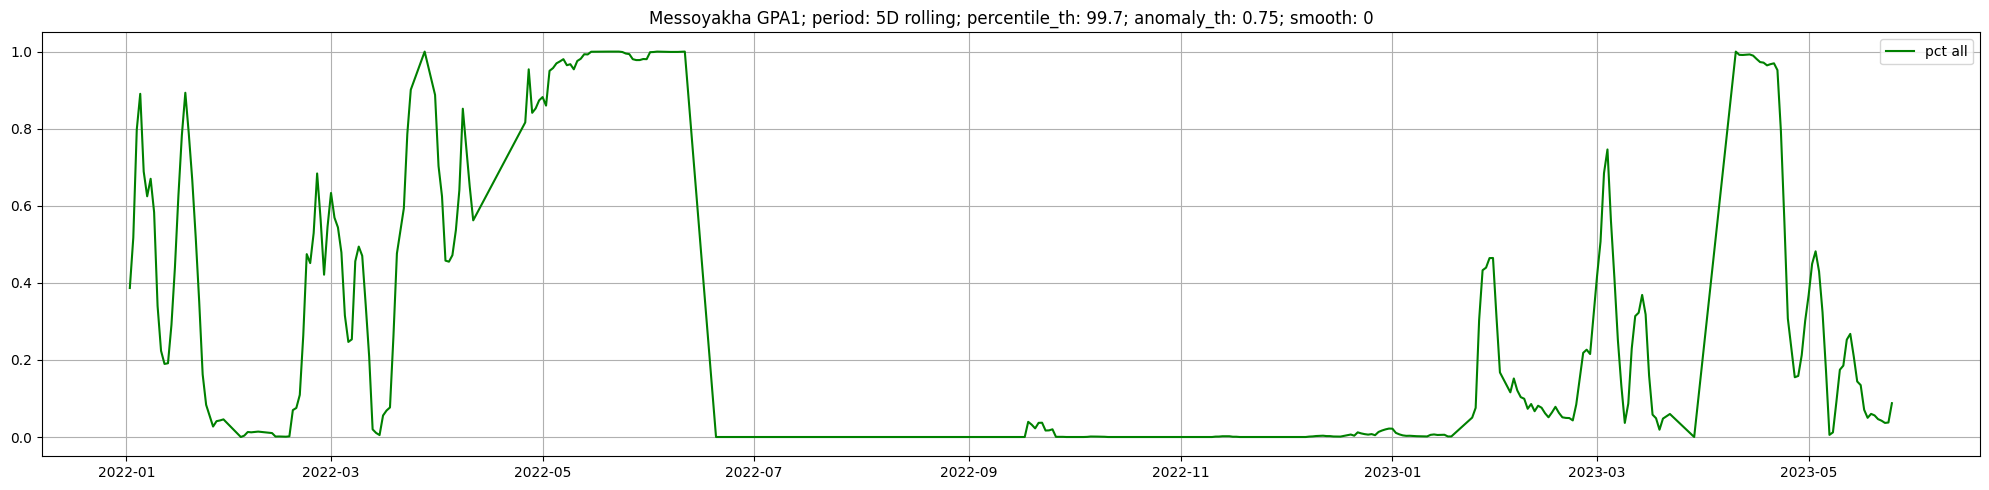

In [24]:
file_name = '{}_{}_{}_rolling_{}_{}_{}.png'.format(COMPANY, EQUIPMENT, freq, percentile_th, anomaly_th, smooth_n)
plt.figure(figsize=(20, 5))
plt.plot(df_periods_grp.index, df_periods_grp['anomaly_pct'], color='g', label='pct all')
#plt.plot(df_periods_grp.index, df_periods_grp['anomaly_pct2'], color='#379BDB', label='pct divergence')
plt.grid(True)
plt.legend(loc='best')
plt.title('{} {}; period: {} rolling; percentile_th: {}; anomaly_th: {}; smooth: {}'.format(COMPANY, 
                                                                                            EQUIPMENT, 
                                                                                            freq, 
                                                                                            percentile_th,
                                                                                            anomaly_th, 
                                                                                            smooth_n))

plt.tight_layout()
plt.savefig(os.path.join(data_path_models, model_replacer[model_name], file_name))
plt.show()
plt.close()

In [36]:
df_tmp = score.loc[pd.to_datetime('01.08.2022 00:00', dayfirst=True):pd.to_datetime('01.10.2022 00:00', dayfirst=True), 
                   '0']
df_tmp.to_excel(os.path.join(data_path, r"models\df_tmp.xlsx"))

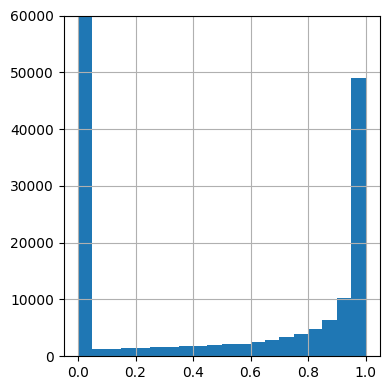

In [109]:
plt.figure(figsize=(4, 4))
plt.hist(score['0'], 20)
plt.grid(True)
plt.ylim([0,60000])
plt.tight_layout()
plt.savefig(os.path.join(data_path_models, model_replacer[model_name], 'score_distribution.png'))
plt.show()
plt.close()

##### Объяснения

In [ ]:
for model_name in model_names:
    print(model_name, df_inference_grp[df_inference_grp['model_names'].str.contains(model_name)].shape[0])

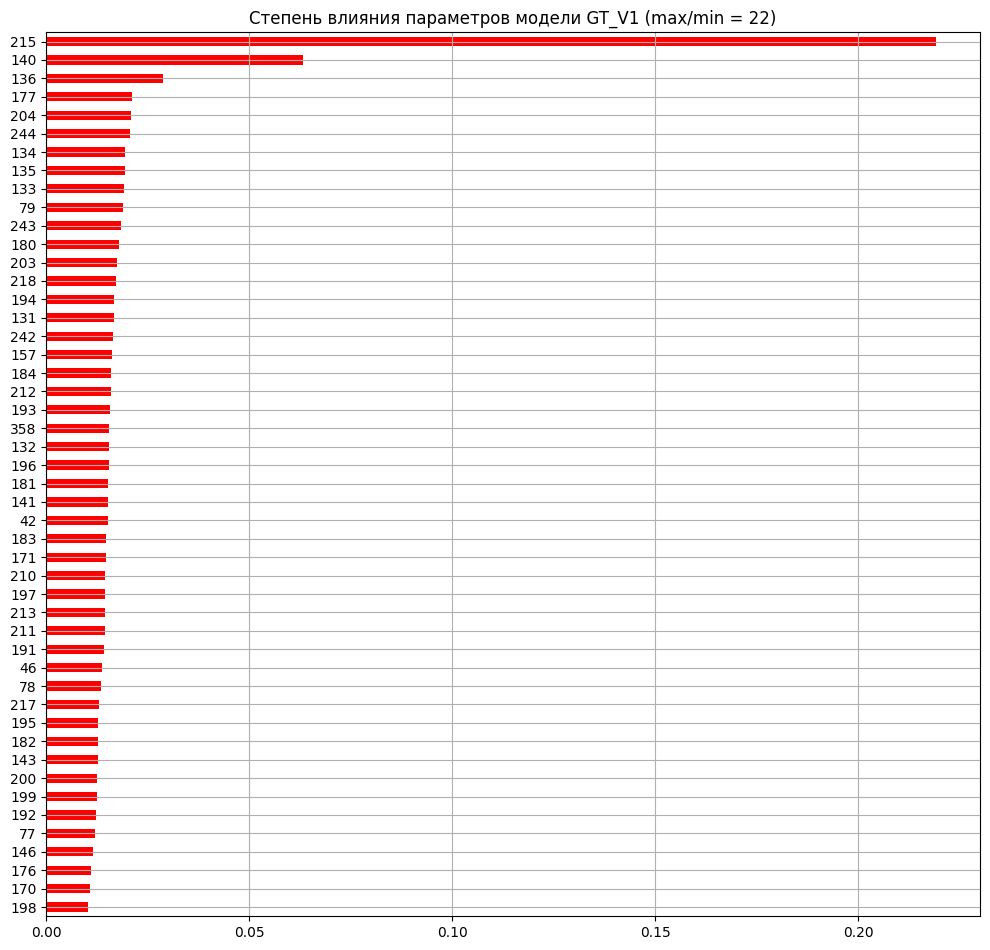

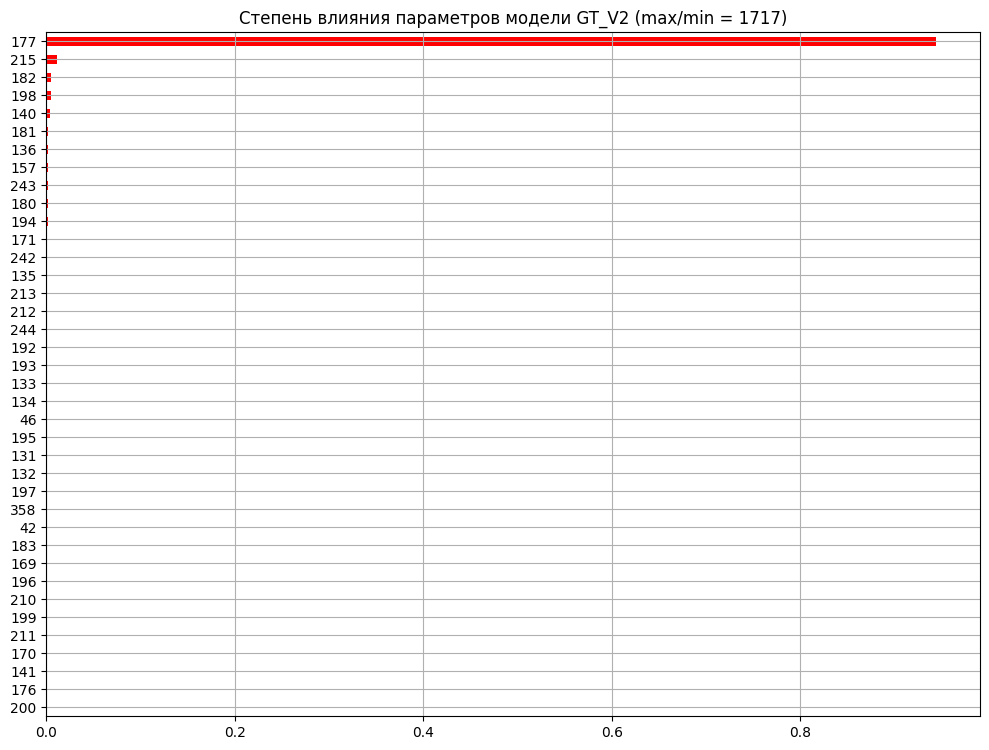

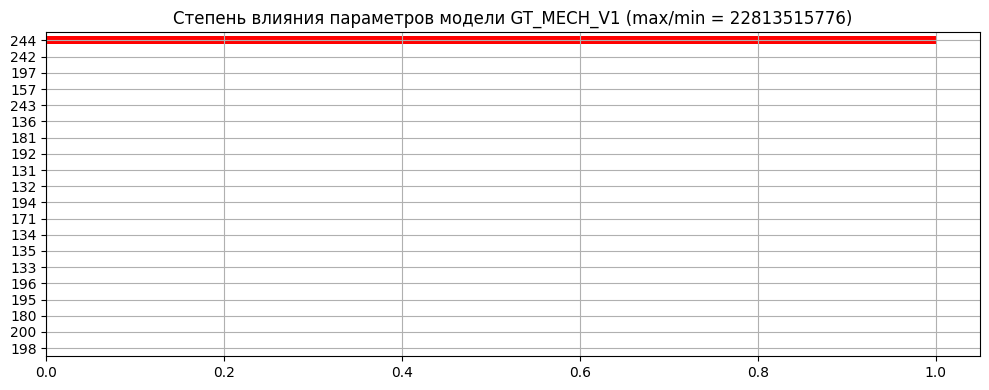

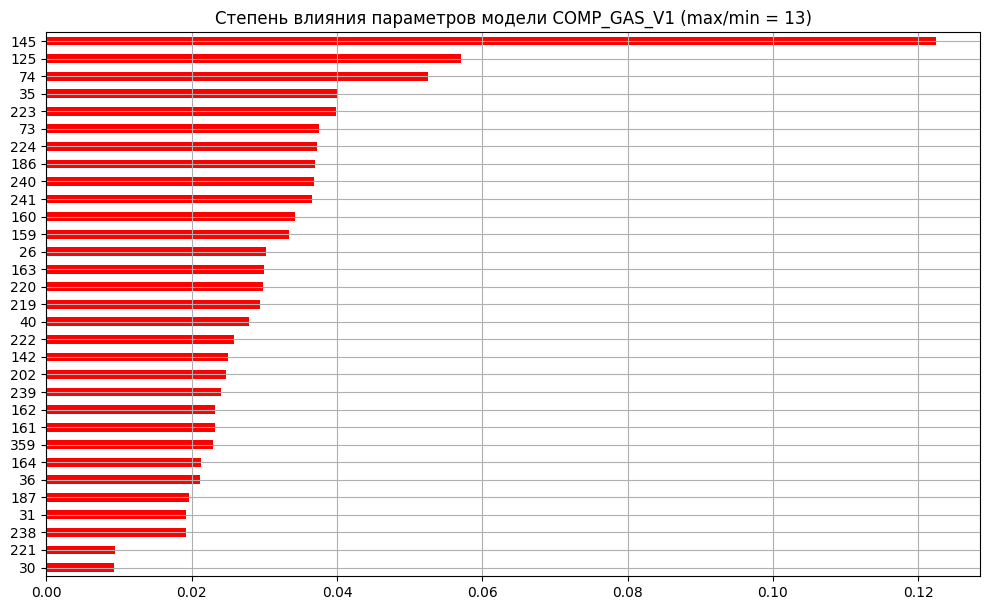

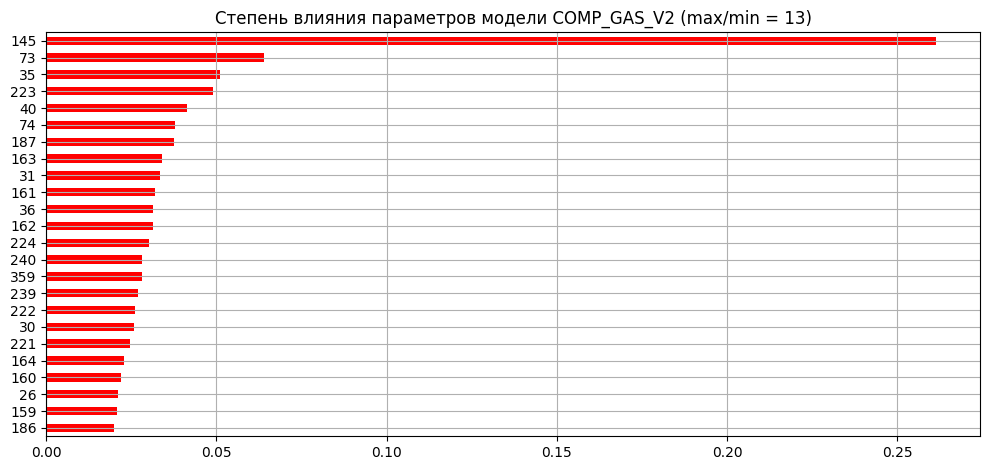

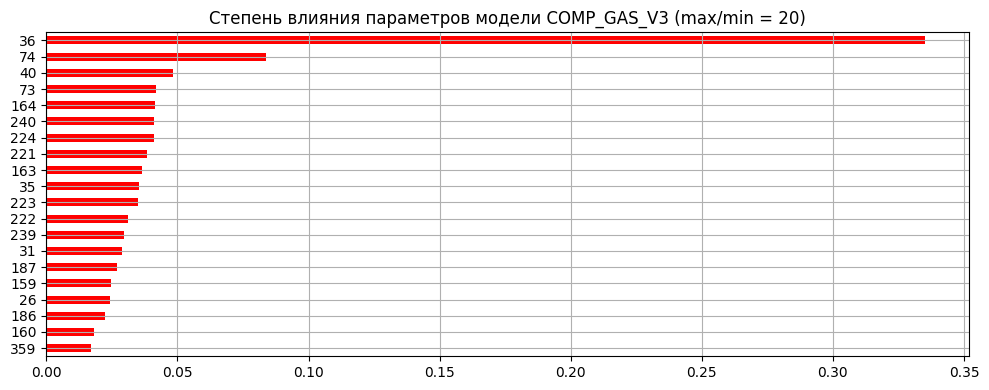

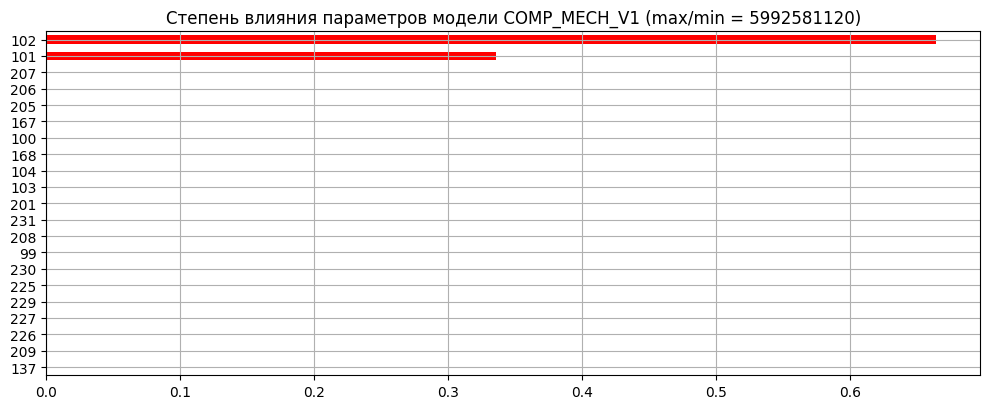

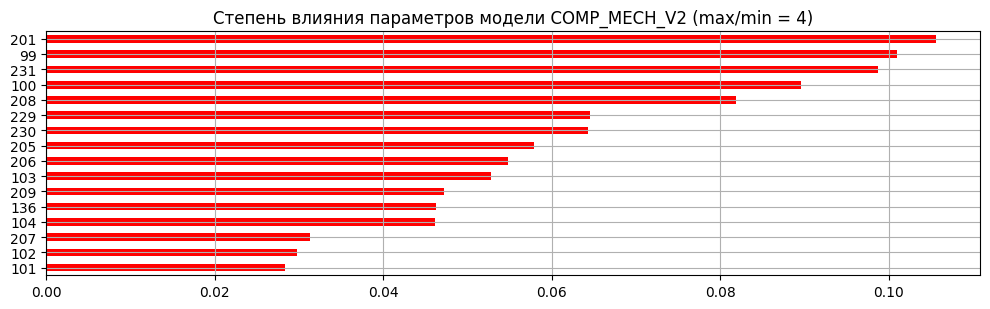

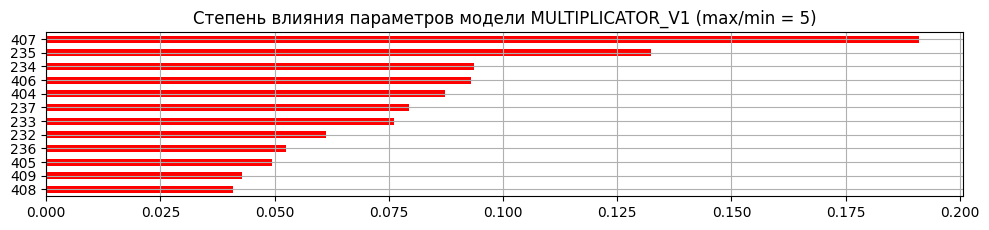

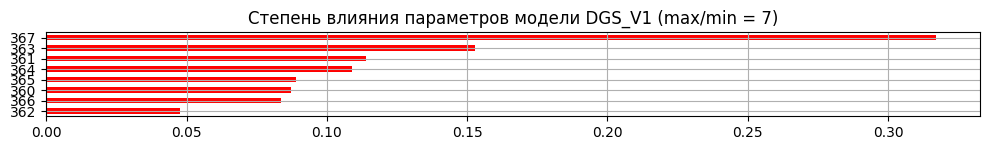

In [67]:
for model_name in model_names:
    #file_path = os.path.join(data_path, 'models', EQUIPMENT, model_name, 'score.parquet')
    data_path_model = os.path.join(data_path, fr'models\Обученные модели\К{EQUIPMENT_NUM}', model_replacer[model_name])
    if os.path.isfile(os.path.join(data_path_model, 'explanation.parquet')):
        exp = pd.read_parquet(os.path.join(data_path_model, 'explanation.parquet'))
        score = pd.read_parquet(os.path.join(data_path_model, 'score.parquet'))
        mask_inference = (~mask_stops) & (score['0'] > 0.25)
        exp = exp[mask_inference]
        
        parameters = exp.sum(axis=0)
        sum_parameters = np.sum(parameters)
        period_explainer = parameters / sum_parameters
        explain_period = pd.Series(period_explainer, index=exp.columns)
        explain_period = explain_period.sort_values()

        plt.figure(figsize=(10, 0.2*len(parameters)))
        title_str = 'Степень влияния параметров модели {} (max/min = {})'.format(model_name, 
                                                                                 round(explain_period.max() / 
                                                                                       explain_period.min()))
        explain_period.plot(kind='barh', title=title_str, grid=True, color='red')
        plt.tight_layout()
        plt.show()
        plt.close()

## Черновик

### Split dataset

In [100]:
df_tags_all1 = pd.read_excel(os.path.join(data_path_systems, fr"{COMPANY}_gpa1_taglist_v5.xlsx"), sheet_name='GPA1')
df_tags_all1['ID'] = df_tags_all1['ID'].astype(int).astype(str)
print(df_tags_all1.shape)
df_tags_all1.head(3)

(1709, 30)


,ID,AgregatName,TagName,Description,Unit,System,Subsystem,Equipment,Comment,is_selected,...,tag_type,Discrete,Ctrl,EvalMetric,Alert,Auxiliary,PID,Aggregation,Setpoint,ID_tag_gpa2
0,215,АВО45,06.02.10.04.009.AVO_45.AVO_A1.checkLink,АВО А1: Контроль наличия связи,None,NaN,NaN,NaN,NaN,0,...,Discrete,1,0,0,0,0,0,0,0,NaN
1,216,АВО45,06.02.10.04.009.AVO_45.AVO_A1.dP11_21,Разность давлений ВХ1.1 dP PT 1.1 вх/вых PT2.1,МПа,Компрессор,KND,AVOG,NaN,1,...,NaN,0,0,0,0,0,0,0,0,746.0
2,217,АВО45,06.02.10.04.009.AVO_45.AVO_A1.dP12_22,Разность давлений ВХ1.2 dP PT 1.2 вх/вых PT2.2,МПа,Компрессор,KND,AVOG,NaN,1,...,NaN,0,0,0,0,0,0,0,0,747.0


In [68]:
tag_names1 = list(df_tags_all1['TagName'].values)
print(len(tag_names1))
print(len(np.unique(tag_names1)))

1709
1709


In [11]:
df_tags_all2 = pd.read_excel(os.path.join(data_path_systems, r"tags_gpa2_v8.xlsx"), sheet_name='GPA2')
df_tags_all2['ID'] = df_tags_all2['ID'].astype(int).astype(str)
print(df_tags_all2.shape)
df_tags_all2.head(3)

(1739, 22)


,ID,AgregatName,TagName,Description,Unit,System,Subsystem,Equipment,Comment,KVD_GAS_M_V1,...,KND_MECH_V1,Drive_m_v1,Geabox_m_V1,DGS_KND_m_v1,DGS_KVD_m_v1,isEvalMetric,isMV,isSetpoint,isDiscrete,isPID
0,3620,GPA2,06.02.10.04.009.GPA2.NKU02.TEST_Set_07UV581,(ТЕСТ) Вентилятор №1 07-УВ581 Регулировка скор...,%,Power supply,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,3639,GPA2,06.02.10.04.009.GPA2.NKU06.TEST_Set_10UV581,(ТЕСТ) Вентилятор №1 10-УВ582 Регулировка скор...,%,Power supply,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,3660,GPA2,06.02.10.04.009.GPA2.NKU08.TEST_Set_07UV582,(ТЕСТ) Вентилятор №2 07-УВ582 Регулировка скор...,%,Power supply,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [70]:
tag_names2 = list(df_tags_all2['TagName'].values)
print(len(tag_names2))
print(len(np.unique(tag_names2)))

1739
1739


In [10]:
#Основной датасет
file_name = fr'MNG_20220101_20220817.parquet'
df_metrics_raw = pd.read_parquet(os.path.join(data_path, 'processed', file_name))
#df_metrics_raw['DateTime'] = pd.to_datetime(df_metrics_raw['DateTime'], format='%Y-%m-%d %H:%M:%S')
#df_metrics_raw.set_index(keys=['DateTime'], inplace=True)
#df_metrics_raw = df_metrics_raw[need_cols]

print(file_name)
print(df_metrics_raw.shape)
print(df_metrics_raw.index.min(), df_metrics_raw.index.max())
print(df_metrics_raw.isna().sum().sum())
df_metrics_raw.head(3)

MNG_20220101_20220817.parquet
(306392, 1830)
2022-01-01 00:01:00 2022-08-17 00:00:00
0


,06.02.10.04.009.AVO_45.AVO_A1.LT4_5_1_1,06.02.10.04.009.AVO_45.AVO_A1.LT4_5_1_2,06.02.10.04.009.AVO_45.AVO_A1.LT4_5_1_3,06.02.10.04.009.AVO_45.AVO_A1.LT4_5_1_4,06.02.10.04.009.AVO_45.AVO_A1.LT4_5_2_1,06.02.10.04.009.AVO_45.AVO_A1.PT4_5_1_1,06.02.10.04.009.AVO_45.AVO_A1.PT4_5_1_2,06.02.10.04.009.AVO_45.AVO_A1.PT4_5_1_3,06.02.10.04.009.AVO_45.AVO_A1.PT4_5_1_4,06.02.10.04.009.AVO_45.AVO_A1.PT4_5_2_1,...,06.02.10.04.009.TDA.pos_RTM301,06.02.10.04.009.TDA.pos_RTM302,06.02.10.04.009.TDA.set_KR106,06.02.10.04.009.TDA.set_KR106_DU,06.02.10.04.009.TDA.set_KR111,06.02.10.04.009.TDA.set_KR111_DU,06.02.10.04.009.TDA.set_RTM302,06.02.10.04.009.TDA.set_RTM302_DU,06.02.10.04.009.TDA.set_VT1,06.02.10.04.009.TDA.set_VT1_DU
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:01:00,7.24616,24.028080,21.978041,37.356522,14.80608,1.444096,3.8152,6.63392,14.47296,1.395584,...,99.839996,81.612,47.591999,47.591999,58.880001,58.880001,81.599998,80.0,20.16,20.16
2022-01-01 00:02:00,7.23344,24.017481,22.016199,37.280201,14.79972,1.470144,3.8376,6.62784,14.40768,1.420160,...,99.839996,81.612,48.112000,48.112000,58.880001,58.880001,81.599998,80.0,20.16,20.16
2022-01-01 00:03:00,7.22284,24.015360,22.048000,37.261120,14.79548,1.499776,3.9200,6.71072,14.49600,1.449792,...,99.856003,81.612,48.136002,48.136002,58.880001,58.880001,81.599998,80.0,20.16,20.16


In [72]:
cols1 = [col for col in df_metrics_raw.columns if col in tag_names1]
print(len(cols1))
cols2 = [col for col in df_metrics_raw.columns if col in tag_names2]
print(len(cols2))

print([col for col in cols1 if col in cols2])
print([col for col in cols2 if col in cols1])

854
864
[]
[]


In [73]:
df_metrics_raw = df_metrics_raw[cols2]
end_pos = pd.to_datetime('01.08.2022 00:00:00', dayfirst=True)
df_metrics_raw = df_metrics_raw.loc[:end_pos, :]
print(df_metrics_raw.shape)
df_metrics_raw.tail(2)

(283368, 864)


,06.02.10.04.009.AVO_55.AVOGPA2A1.LT4_5_1_1,06.02.10.04.009.AVO_55.AVOGPA2A1.LT4_5_1_2,06.02.10.04.009.AVO_55.AVOGPA2A1.LT4_5_1_3,06.02.10.04.009.AVO_55.AVOGPA2A1.LT4_5_1_4,06.02.10.04.009.AVO_55.AVOGPA2A1.LT4_5_2_1,06.02.10.04.009.AVO_55.AVOGPA2A1.PT4_5_1_1,06.02.10.04.009.AVO_55.AVOGPA2A1.PT4_5_1_2,06.02.10.04.009.AVO_55.AVOGPA2A1.PT4_5_1_3,06.02.10.04.009.AVO_55.AVOGPA2A1.PT4_5_1_4,06.02.10.04.009.AVO_55.AVOGPA2A1.PT4_5_2_1,...,06.02.10.04.009.GPA2.NKU_DRV.PCH3_AI_5,06.02.10.04.009.GPA2.NKU_DRV.PCH3_AI_7,06.02.10.04.009.GPA2.NKU_DRV.PCH3_AI_8,06.02.10.04.009.GPA2.NKU_DRV.PCH3_AI_9,06.02.10.04.009.GPA2.NKU_DRV.PCH4_AI_6,06.02.10.04.009.GPA2.NKU_DRV.PCH4_AI_7,06.02.10.04.009.GPA2.NKU_DRV.PCH4_AI_8,06.02.10.04.009.GPA2.NKU_DRV.PCH4_AI_9,06.02.10.04.009.GPA2.NKU_DRV.loadCPU,06.02.10.04.009.GPA2.UPD.loadCPU
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-07-31 23:59:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,170.0,9.56,18.240000,1.84,526.0,10.08,70.239998,10.80,2.016,0.456
2022-08-01 00:00:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,156.0,9.36,17.440001,1.76,526.0,10.00,69.879997,10.76,2.044,0.464


In [74]:
df_tags_all2 = df_tags_all2[df_tags_all2['TagName'].isin(cols2)]
replacer2 = pd.Series(df_tags_all2['ID'].values, index=df_tags_all2['TagName'])
print(df_tags_all2.shape)

(864, 22)


In [75]:
df_metrics_raw.rename(columns=replacer2, inplace=True)
print(df_metrics_raw.shape)
df_metrics_raw.tail(2)

(283368, 864)


,751,752,753,754,755,763,764,765,766,767,...,3586,3588,3589,3590,3602,3603,3604,3605,3425,3662
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-07-31 23:59:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,170.0,9.56,18.240000,1.84,526.0,10.08,70.239998,10.80,2.016,0.456
2022-08-01 00:00:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,156.0,9.36,17.440001,1.76,526.0,10.00,69.879997,10.76,2.044,0.464


In [76]:
#Основной датасет
file_name = fr'MNG_20220801_20230601.parquet'
df_metrics_raw_new = pd.read_parquet(os.path.join(data_path, 'processed', file_name))
print(file_name)
print(df_metrics_raw_new.shape)
print(df_metrics_raw_new.index.min(), df_metrics_raw_new.index.max())
print(df_metrics_raw_new.isna().sum().sum())
df_metrics_raw_new.head(3)

MNG_20220801_20230601.parquet
(436261, 1830)
2022-08-01 00:01:00 2023-06-01 00:00:00
0


TagName,06.02.10.04.009.AVO_45.AVO_A1.LT4_5_1_1,06.02.10.04.009.AVO_45.AVO_A1.LT4_5_1_2,06.02.10.04.009.AVO_45.AVO_A1.LT4_5_1_3,06.02.10.04.009.AVO_45.AVO_A1.LT4_5_1_4,06.02.10.04.009.AVO_45.AVO_A1.LT4_5_2_1,06.02.10.04.009.AVO_45.AVO_A1.PT4_5_1_1,06.02.10.04.009.AVO_45.AVO_A1.PT4_5_1_2,06.02.10.04.009.AVO_45.AVO_A1.PT4_5_1_3,06.02.10.04.009.AVO_45.AVO_A1.PT4_5_1_4,06.02.10.04.009.AVO_45.AVO_A1.PT4_5_2_1,...,06.02.10.04.009.TDA.pos_RTM301,06.02.10.04.009.TDA.pos_RTM302,06.02.10.04.009.TDA.set_KR106,06.02.10.04.009.TDA.set_KR106_DU,06.02.10.04.009.TDA.set_KR111,06.02.10.04.009.TDA.set_KR111_DU,06.02.10.04.009.TDA.set_RTM302,06.02.10.04.009.TDA.set_RTM302_DU,06.02.10.04.009.TDA.set_VT1,06.02.10.04.009.TDA.set_VT1_DU
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-08-01 00:01:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,250.139999,250.139999,250.139999,100.0,250.139999,0.0,250.139999,100.0,250.139999,0.0
2022-08-01 00:02:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,250.139999,250.139999,250.139999,100.0,250.139999,0.0,250.139999,100.0,250.139999,0.0
2022-08-01 00:03:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,250.139999,250.139999,250.139999,100.0,250.139999,0.0,250.139999,100.0,250.139999,0.0


In [77]:
df_metrics_raw_new = df_metrics_raw_new[cols2]
df_metrics_raw_new.rename(columns=replacer2, inplace=True)
df_metrics_raw_new = df_metrics_raw_new[df_metrics_raw.columns]
print(df_metrics_raw_new.shape)
df_metrics_raw_new.head(2)

(436261, 864)


TagName,751,752,753,754,755,763,764,765,766,767,...,3586,3588,3589,3590,3602,3603,3604,3605,3425,3662
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-08-01 00:01:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,158.0,9.52,18.440001,1.84,524.960022,10.20,71.279999,10.96,2.100,0.448
2022-08-01 00:02:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,166.0,9.48,18.240000,1.84,526.000000,10.12,70.720001,10.88,2.056,0.460


In [78]:
df_metrics_raw = pd.concat([df_metrics_raw, df_metrics_raw_new])
df_metrics_raw.sort_index(inplace=True)
print(df_metrics_raw.shape)
df_metrics_raw.head(2)

(719629, 864)


,751,752,753,754,755,763,764,765,766,767,...,3586,3588,3589,3590,3602,3603,3604,3605,3425,3662
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:01:00,1.22536,11.41408,-0.36888,22.361759,3.43652,1.441472,3.84064,6.66624,14.48768,1.349952,...,164.0,9.72,18.68,1.88,529.0,7.12,25.160000,3.44,2.032,0.464
2022-01-01 00:02:00,1.24444,11.40136,-0.36464,22.397800,3.42804,1.473344,3.87472,6.67296,14.42048,1.376576,...,158.0,9.60,18.68,1.88,526.0,9.48,72.760002,10.00,2.128,0.448


In [79]:
start_pos = pd.to_datetime('31.07.2022 23:58:00', dayfirst=True)
end_pos = pd.to_datetime('01.08.2022 00:02:00', dayfirst=True)
df_metrics_raw.loc[start_pos:end_pos, :]

,751,752,753,754,755,763,764,765,766,767,...,3586,3588,3589,3590,3602,3603,3604,3605,3425,3662
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-07-31 23:58:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,172.0,9.56,17.959999,1.80,526.000000,10.04,69.239998,10.64,2.016,0.448
2022-07-31 23:59:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,170.0,9.56,18.240000,1.84,526.000000,10.08,70.239998,10.80,2.016,0.456
2022-08-01 00:00:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,156.0,9.36,17.440001,1.76,526.000000,10.00,69.879997,10.76,2.044,0.464
2022-08-01 00:01:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,158.0,9.52,18.440001,1.84,524.960022,10.20,71.279999,10.96,2.100,0.448
2022-08-01 00:02:00,132.574203,132.574203,132.574203,132.574203,132.574203,4.00224,10.0056,20.0112,40.0224,4.00224,...,166.0,9.48,18.240000,1.84,526.000000,10.12,70.720001,10.88,2.056,0.460


In [80]:
df_metrics_raw.to_parquet(os.path.join(data_path_processed, EQUIPMENT+'_20220101_20230601.parquet'))
print(df_metrics_raw.shape)

(719629, 864)


In [ ]:
['2498', '2501', '2820', '2821', '2849', '2850', '3088', '3089', '3285', '3286', '3302', '3303', '3327', '3338']

In [56]:
df_tags_all2[['ID', 'TagName']][df_tags_all2['ID'] == '3338']

,ID,TagName
1240,3338,06.02.10.04.009.GPA2.AB2.PRU_AO6


In [57]:
col = df_tags_all2[['TagName']][df_tags_all2['ID'] == '3338'].values[0][0]
print(col)
[col for col in [col] if col in df_metrics_raw.columns]

06.02.10.04.009.GPA2.AB2.PRU_AO6


[]

In [38]:
col = '1394'
print(snr(df_metrics[col]))

0.406203966666001


### Decision model

In [32]:
import shap
from hyperopt import fmin, hp, tpe, Trials, space_eval
from hyperopt.pyll import scope
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split

In [40]:
anomaly_th = 0.75

def lgbm_optimize_hp(X_train, y_train, task_type='regression'):
    def objective(params):
        if task_type == 'regression':
            lgb = LGBMRegressor(n_estimators=200, **params)
        elif task_type == 'classification':
            lgb = LGBMClassifier(n_estimators=200, **params)

        score = cross_val_score(lgb, X_train, y_train, cv=3).mean()
        return score
    
    if task_type == 'regression':
        metric = 'rmse'
        objective_ = 'regression'
    elif task_type == 'classification':
        metric = 'logloss'
        objective_ = 'binary'
    
    hyperopt_space = {
        'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
        'bagging_freq': 5,
        'boosting_type': 'gbdt',
        'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
        'lambda_l1': hp.uniform('lambda_l1', 1e-4, 2),
        'lambda_l2': hp.uniform('lambda_l2', 1e-4, 2),
        'learning_rate': hp.quniform('learning_rate', 0.01, 0.4, 0.01),
        'max_bin': 255,
        'max_depth': scope.int(hp.quniform('max_depth', 2, 10, 1)),
        'metric': metric,
        'min_data_in_leaf': scope.int(hp.quniform('min_data_in_leaf', 10, 150, 1)),
        'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', 0, 2.3),
        'num_leaves': scope.int(hp.quniform('num_leaves', 100, 500, 1)),
        'objective': objective_,
        'verbose': -1
    }

    trials = Trials()
    best = fmin(fn=objective,
                space=hyperopt_space,
                algo=tpe.suggest,
                max_evals=10,
                trials=trials,
                rstate=np.random.default_rng(42),
                verbose=-1
                )
    hyper_params_optimized = space_eval(hyperopt_space, best)
    
    return hyper_params_optimized

In [52]:
df = exp.copy()
df['prob_true'] = score['0']
abs(df.corr()['prob_true']).sort_values(ascending=False)

prob_true    1.000000
1356         0.659316
1319         0.659230
1312         0.534849
1796         0.438843
1360         0.416274
1316         0.365525
2200         0.338515
1394         0.296845
Name: prob_true, dtype: float64

In [53]:
df['target_true'] = 0
df.loc[score['0'] > anomaly_th, 'target_true'] = 1
df['target_true'] = df['target_true'].astype(int)
print(sum(df['target_true']))

74464


In [54]:
train_end = pd.to_datetime('12.03.2023 23:59:00', dayfirst=True)
X_train = exp.loc[:train_end]
y_train = df.loc[:train_end, 'target_true']

test_start = pd.to_datetime('13.03.2023 00:00:00', dayfirst=True)
X_test = exp.loc[test_start:]
y_test = df.loc[test_start:, 'target_true']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=7, shuffle=False)

print(X_train.shape)
print(y_train.shape)
print(sum(y_train) / y_train.shape[0])
print(X_val.shape)
print(y_val.shape)
print(sum(y_val) / y_val.shape[0])
print(X_test.shape)
print(y_test.shape)
print(sum(y_test) / y_test.shape[0])

(234690, 8)
(234690,)
0.20394989134603095
(41417, 8)
(41417,)
0.2379940604099766
(52675, 8)
(52675,)
0.3178357854769815


In [55]:
#X_train.tail(3)
X_test.head(3)

,1312,1316,1319,1356,1360,1394,1796,2200
DateTime,,,,,,,,
2023-03-13 00:00:00,2.744288,1.449185,1.501115,1.508695,0.004398,0.746367,1.469088,1.153461
2023-03-13 00:01:00,2.986392,1.581800,1.228527,1.235794,0.169644,0.842669,1.456939,1.326810
2023-03-13 00:02:00,3.237286,1.724315,0.955466,0.962447,0.342951,0.932643,1.445634,1.496796


In [56]:
hyper_params_optimized = lgbm_optimize_hp(X_train=pd.concat([X_train, X_val]), 
                                          y_train=pd.concat([y_train, y_val]), 
                                          task_type='classification')

lgb = LGBMClassifier(n_estimators=200, **hyper_params_optimized)
lgb.fit(X=X_train, 
        y=y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='logloss',
        early_stopping_rounds=10,
        verbose=-1)

[LightGBM] [Warning] feature_fraction is set=0.8309997589288585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8309997589288585
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=1.4311453623802879, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4311453623802879
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.163157058146627, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.163157058146627
[LightGBM] [Warning] bagging_fraction is set=0.8710462264596228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8710462264596228
[LightGBM] [Warning] lambda_l2 is set=0.2276811547404959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2276811547404959
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5            
[LightGBM] [Warning]

LGBMClassifier(bagging_fraction=0.8131057513737824, bagging_freq=5,
               feature_fraction=0.8958829006117095,
               lambda_l1=0.41196174151598447, lambda_l2=1.0015511447291563,
               learning_rate=0.04, max_bin=255, max_depth=8, metric='logloss',
               min_data_in_leaf=93, min_sum_hessian_in_leaf=1.6292167357049803,
               n_estimators=200, num_leaves=262, objective='binary',
               verbose=-1)

In [59]:
df_test = X_test.copy()
df_test['target_true'] = y_test
df_test['target_pred'] = lgb.predict(X_test)
df_test['prob_true'] = df.loc[test_start:, 'prob_true']
df_test['prob_pred'] = lgb.predict_proba(X_test)[:, 1]
print(df_test.shape)
print(X_test.index.min(), X_test.index.max())

(52675, 12)
2023-03-13 00:00:00 2023-05-25 23:33:00


In [61]:
f1 = round(f1_score(y_true=df_test['target_true'], y_pred=df_test['target_pred']), 3)
print('F1={}'.format(f1))
roc_auc = round(roc_auc_score(df_test['target_true'], df_test['prob_pred']), 3)
print('ROC AUC={}'.format(roc_auc))

F1=0.371
ROC AUC=0.955


In [62]:
rmse = round(mean_squared_error(y_true=df_test['prob_true'], y_pred=df_test['prob_pred'], squared=False), 3)
print('RMSE={}'.format(rmse))
mae = round(mean_absolute_error(y_true=df_test['prob_true'], y_pred=df_test['prob_pred']), 3)
print('MAE={}'.format(mae))

RMSE=0.421
MAE=0.255


In [63]:
df_all = exp.copy()
df_all['prob_true'] = score['0']
df_all['prob_pred'] = lgb.predict_proba(exp)[:, 1]
print(df_all.shape)
print(df_all.index.min(), df_all.index.max())

(328782, 10)
2022-01-02 00:32:00 2023-05-25 23:33:00


In [64]:
print(df_all[(df_all['prob_true'] > anomaly_th)].shape)
print(df_all[(df_all['prob_pred'] > anomaly_th)].shape)
mask = ((df_all['prob_true'] > anomaly_th) & (df_all['prob_pred'] > anomaly_th))
print(sum(mask))
df_all.loc[~mask, 'prob_true'] = 0.0
print(df_all[mask].shape)

(74464, 10)
(56001, 10)
55894
(55894, 10)


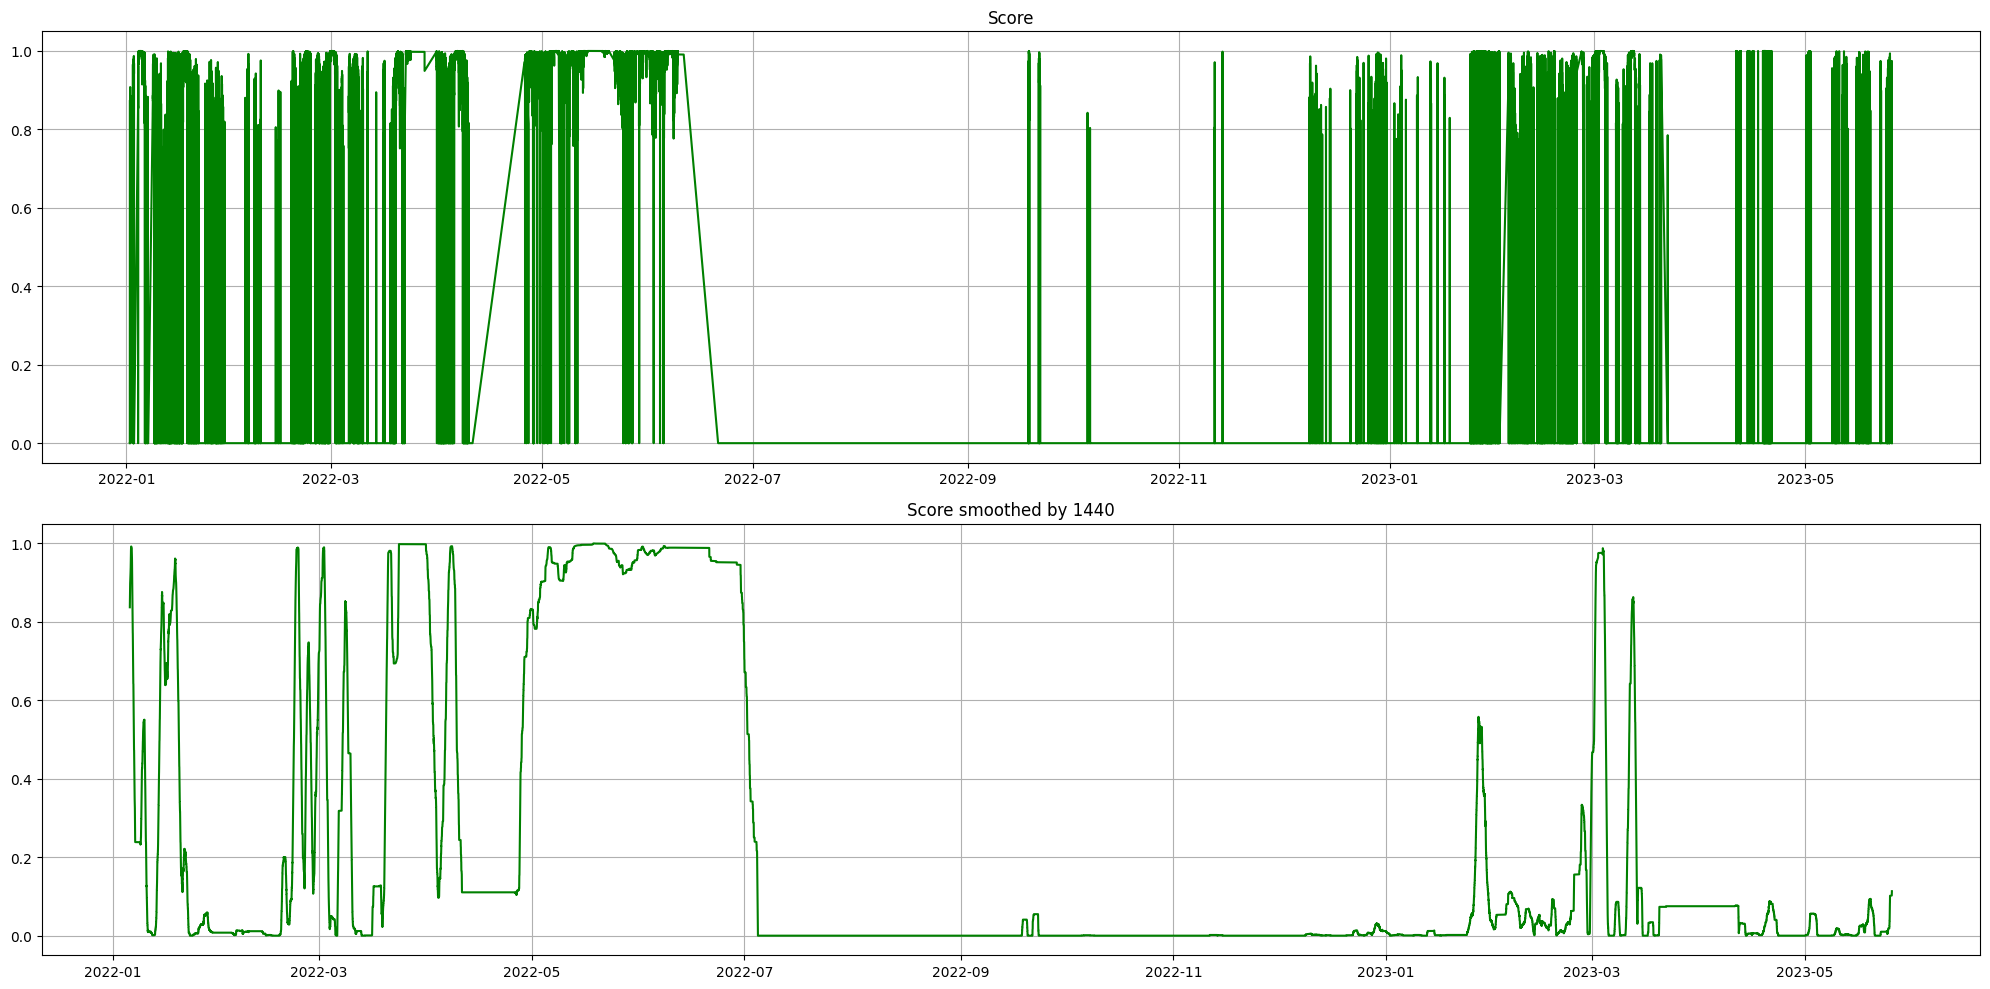

In [66]:
start_date = '02.01.2022 00:00' 
end_date = '25.05.2023 23:33'
smooth_n = 60*24*1

plot_score(df_score=df_all, 
           start_date=start_date, 
           end_date=end_date,
           score_col='prob_true',
           smooth_n=smooth_n)

In [69]:
start_pos = pd.to_datetime(start_date, dayfirst=True)
end_pos = pd.to_datetime(end_date, dayfirst=True)

score_tmp = df_all.loc[start_pos:end_pos, 'prob_true'].copy()
score_s = score_tmp.rolling(smooth_n).mean()
score_s = score_s[smooth_n-1:]

In [72]:
score_tmp = df_all.loc[start_pos:end_pos, 'prob_true']
#score_tmp = score_s.loc[start_pos:end_pos]
print(score_tmp.shape)
print(score_tmp[score_tmp == 0].shape)
print(score_tmp[(score_tmp > anomaly_th)].shape)
print(score_tmp[score_tmp == 1].shape)

periods = pd.period_range(start=score_tmp.index.min(), 
                          end=score_tmp.index.max(),
                          freq='M')
for i, _ in enumerate(periods):
    period_name = periods[i].strftime('%Y-%m')
    score_tmp1 = score_tmp[period_name]
    anomaly_cnt = score_tmp1[(score_tmp1 > anomaly_th)].shape[0]
    print(period_name, score_tmp1.shape[0], anomaly_cnt, anomaly_cnt / score_tmp1.shape[0])

(328782,)
(272888,)
(55894,)
(0,)
2022-01 27261 9307 0.341403470158835
2022-02 22524 5550 0.2464038359083644
2022-03 19874 7662 0.3855288316393278
2022-04 8856 5310 0.5995934959349594
2022-05 12924 12676 0.9808108944599195
2022-06 6222 5796 0.9315332690453231
2022-07 4661 0 0.0
2022-08 13624 0 0.0
2022-09 21492 152 0.007072399032198027
2022-10 28860 2 6.93000693000693e-05
2022-11 26077 5 0.0001917398473750815
2022-12 28194 135 0.004788252819748883
2023-01 23453 2016 0.08595915234724769
2023-02 20322 1890 0.09300265721877768
2023-03 20343 4630 0.2275967163151944
2023-04 19030 248 0.01303205465055176
2023-05 25065 515 0.02054657889487333
